# XGBoost Parameter Tuning for Trial User Predictions

This notebook performs grid search to find the optimal XGBoost parameters for predicting expected proceeds for trial users. We'll evaluate different parameter combinations on 5 random inference dates between 2025-02-01 and 2025-03-01.

In [4]:
# Install required packages
!pip install numpy==1.23.5
!pip install pandas==1.5.3
!pip install pyarrow==10.0.1
!pip install "snowflake-connector-python[pandas]"
!pip install snowflake-snowpark-python
!pip install tqdm
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn
!pip install xgboost

zsh:1: command not found: pip
zsh:1: command not found: pip
zsh:1: command not found: pip
zsh:1: command not found: pip
zsh:1: command not found: pip
zsh:1: command not found: pip
zsh:1: command not found: pip
zsh:1: command not found: pip
zsh:1: command not found: pip
zsh:1: command not found: pip


In [16]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import ParameterGrid
import os
import sys

# Add the parent directory to the path to import custom modules
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Import custom modules
from data_utils import split_data_by_date, split_data_by_user_type
from country_utils import add_signup_country_group
from trial_predictions import TrialPredictionModel

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

## 1. Connect to Snowflake and Load Data

In [6]:
# Import Snowflake connection config
import config

# Snowflake connection
from snowflake.snowpark import Session

def get_snowflake_session():
    """Create and return a Snowflake session"""
    connection_parameters = {
        "account": config.SNOWFLAKE_ACCOUNT,
        "user": config.SNOWFLAKE_USER,
        "role": config.SNOWFLAKE_ROLE,
        "warehouse": config.SNOWFLAKE_WAREHOUSE,
        "database": config.SNOWFLAKE_DATABASE,
        "schema": config.SNOWFLAKE_SCHEMA,
        "authenticator": config.SNOWFLAKE_AUTHENTICATOR
    }
    
    session = Session.builder.configs(connection_parameters).create()
    print(f"Connected to Snowflake as {config.SNOWFLAKE_USER}")
    return session

# Create a Snowflake session
session = get_snowflake_session()

Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...
Going to open: https://blinkist-useast_1_virginia.snowflakecomputing.com/console/login?login_name=meri-kris.jaama%40go1.com&browser_mode_redirect_port=57803&proof_key=MnMLlFaCxZphEOllrgas1n3SxhcZanwsQuwxDZGAQmM%3D to authenticate...
Connected to Snowflake as meri-kris.jaama@go1.com


In [7]:
# Fetch data from Snowflake
print("Loading data from Snowflake...")
input_query = """
    SELECT 
        *
    FROM BLINKIST_PRODUCTION.CORE_BUSINESS.EXP_PROCEEDS_INPUT
    """
    
input_df = session.sql(input_query).to_pandas()

product_query = """
    select sku as product_name, price 
    from BLINKIST_PRODUCTION.reference_tables.product_dim
    where is_purchasable;
    """
    
product_df = session.sql(product_query).to_pandas()

print(f"Loaded {len(input_df)} input records and {len(product_df)} product records")

# Convert column names to lowercase for compatibility with utility functions
input_df.columns = input_df.columns.str.lower()
print("Column names converted to lowercase")

# Add country groups
print("Adding country groups...")
input_df = add_signup_country_group(input_df)
print("Country groups added")

Loading data from Snowflake...
Loaded 8113320 input records and 833 product records
Column names converted to lowercase
Adding country groups...


/Users/meri-kris/Documents/GitHub/blinkist-expected-proceeds/exploration/country_utils.py:37: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  us_df = temp_df.loc[(temp_df.report_date >= six_months_ago) & (temp_df.signup_country == "US") & (
/Users/meri-kris/Documents/GitHub/blinkist-expected-proceeds/exploration/country_utils.py:54: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  row_df = temp_df.loc[(temp_df.report_date >= six_months_ago) & (


Country groups added


## 2. Generate Random Inference Dates

In [8]:
def generate_random_dates(start_date, end_date, n=5):
    """Generate n random dates between start_date and end_date"""
    start = datetime.strptime(start_date, "%Y-%m-%d")
    end = datetime.strptime(end_date, "%Y-%m-%d")
    
    date_range = (end - start).days
    random_days = sorted(random.sample(range(date_range), n))
    
    random_dates = [(start + timedelta(days=day)).strftime("%Y-%m-%d") for day in random_days]
    return random_dates

# Generate 5 random dates between 2025-02-01 and 2025-03-01
inference_dates = generate_random_dates("2025-02-01", "2025-03-01", 5)
print("Random inference dates:")
for date in inference_dates:
    print(f"- {date}")

Random inference dates:
- 2025-02-03
- 2025-02-18
- 2025-02-19
- 2025-02-22
- 2025-02-24


## 3. Define Parameter Grid for XGBoost

In [9]:
# Define parameter grid for XGBoost
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Generate all parameter combinations
param_combinations = list(ParameterGrid(param_grid))
print(f"Total parameter combinations: {len(param_combinations)}")

# Display first 3 combinations as example
pd.DataFrame(param_combinations[:3])

Total parameter combinations: 243


,colsample_bytree,learning_rate,max_depth,n_estimators,subsample
0,0.6,0.01,3,50,0.6
1,0.6,0.01,3,50,0.8
2,0.6,0.01,3,50,1.0


## 3. Define Evaluation Function

In [10]:
def evaluate_model(model, test_df, actual_proceeds_col='eur_proceeds_d8'):
    """Evaluate model performance using various metrics"""
    # Make predictions
    predictions_df = model.predict(test_df)
    
    # Filter to only users who have actual proceeds data
    eval_df = predictions_df[predictions_df[actual_proceeds_col].notna()].copy()
    
    if len(eval_df) == 0:
        return {
            'rmse': np.nan,
            'mae': np.nan,
            'r2': np.nan,
            'mean_error': np.nan,
            'median_error': np.nan
        }
    
    # Calculate errors
    y_true = eval_df[actual_proceeds_col]
    y_pred = eval_df['expected_proceeds_d8']
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    errors = y_pred - y_true
    mean_error = errors.mean()
    median_error = errors.median()
    
    return {
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'mean_error': mean_error,
        'median_error': median_error
    }

## 4. Run Grid Search for Each Inference Date

In [19]:
def run_grid_search_for_date(session, inference_date, param_combinations, training_window_days=180):
    """Run grid search for a specific inference date"""
    print(f"\nProcessing inference date: {inference_date}")
    
    # Split data by date
    inference_df, training_d8_df, training_d100_df = split_data_by_date(
        input_df,
        inference_date=inference_date,
        training_window_days=training_window_days,
        date_column='report_date'
    )
    
    # Split data by user type
    trial_inference, _, _ = split_data_by_user_type(inference_df)
    trial_training_d8, _, _ = split_data_by_user_type(training_d8_df)
    trial_training_d100, _, _ = split_data_by_user_type(training_d100_df)
    
    print(f"Trial users: {len(trial_inference)} inference, {len(trial_training_d8)} training d8")
    
    # Run grid search
    results = []
    
    # Use standard tqdm instead of notebook version
    from tqdm import tqdm as std_tqdm
    
    for params in std_tqdm(param_combinations, desc=f"Parameter combinations for {inference_date}"):
        # Create and train model with current parameters
        model = TrialPredictionModel(product_dim_df=product_df)
        
        # Set model parameters
        model.xgb_params = params
        
        # Train model
        model.fit(trial_training_d8, trial_training_d100)
        
        # Evaluate model
        metrics = evaluate_model(model, trial_inference)
        
        # Store results
        result = {
            'inference_date': inference_date,
            **params,
            **metrics
        }
        results.append(result)
    
    return pd.DataFrame(results)

In [21]:

# Run grid search for each inference date
all_results = []

for date in inference_dates:
    date_results = run_grid_search_for_date(session, date, param_combinations)
    all_results.append(date_results)

# Combine results
grid_search_results = pd.concat(all_results, ignore_index=True)


Processing inference date: 2025-02-03
Trial users: 271 inference, 67366 training d8


Parameter combinations for 2025-02-03:   0%|          | 0/243 [00:00<?, ?it/s]

Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...
Creating XGBClassifier...
Training model with X shape: (67366, 47), y shape: (67366,)
y unique values: [0 1]


Parameter combinations for 2025-02-03:   0%|          | 1/243 [00:00<02:10,  1.86it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:   1%|          | 2/243 [00:01<02:11,  1.83it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:   1%|          | 3/243 [00:01<02:22,  1.68it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:   2%|▏         | 4/243 [00:02<02:25,  1.64it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:   2%|▏         | 5/243 [00:02<02:16,  1.74it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:   2%|▏         | 6/243 [00:03<02:16,  1.74it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:   3%|▎         | 7/243 [00:03<02:11,  1.79it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:   3%|▎         | 8/243 [00:04<02:04,  1.88it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:   4%|▎         | 9/243 [00:04<02:00,  1.95it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:   4%|▍         | 10/243 [00:05<02:04,  1.87it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:   5%|▍         | 11/243 [00:06<02:05,  1.85it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:   5%|▍         | 12/243 [00:06<02:02,  1.89it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:   5%|▌         | 13/243 [00:07<01:58,  1.94it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:   6%|▌         | 14/243 [00:07<01:55,  1.99it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:   6%|▌         | 15/243 [00:08<01:52,  2.02it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:   7%|▋         | 16/243 [00:08<01:51,  2.03it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:   7%|▋         | 17/243 [00:09<01:57,  1.93it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:   7%|▋         | 18/243 [00:09<01:54,  1.96it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:   8%|▊         | 19/243 [00:10<01:52,  1.98it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:   8%|▊         | 20/243 [00:10<01:50,  2.02it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:   9%|▊         | 21/243 [00:11<01:48,  2.04it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:   9%|▉         | 22/243 [00:11<01:48,  2.04it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:   9%|▉         | 23/243 [00:12<01:52,  1.96it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  10%|▉         | 24/243 [00:12<01:51,  1.96it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  10%|█         | 25/243 [00:13<01:53,  1.92it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  11%|█         | 26/243 [00:13<01:51,  1.95it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  11%|█         | 27/243 [00:14<01:50,  1.95it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  12%|█▏        | 28/243 [00:14<01:48,  1.98it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  12%|█▏        | 29/243 [00:15<01:48,  1.98it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  12%|█▏        | 30/243 [00:15<01:46,  2.01it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  13%|█▎        | 31/243 [00:16<01:46,  1.99it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  13%|█▎        | 32/243 [00:16<01:44,  2.02it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  14%|█▎        | 33/243 [00:17<01:43,  2.02it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  14%|█▍        | 34/243 [00:17<01:42,  2.04it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  14%|█▍        | 35/243 [00:18<01:42,  2.04it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  15%|█▍        | 36/243 [00:18<01:43,  1.99it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  15%|█▌        | 37/243 [00:19<01:44,  1.98it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  16%|█▌        | 38/243 [00:19<01:42,  2.01it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  16%|█▌        | 39/243 [00:20<01:44,  1.96it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  16%|█▋        | 40/243 [00:20<01:52,  1.81it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  17%|█▋        | 41/243 [00:21<01:48,  1.86it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  17%|█▋        | 42/243 [00:21<01:46,  1.89it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  18%|█▊        | 43/243 [00:22<01:47,  1.86it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  18%|█▊        | 44/243 [00:22<01:46,  1.88it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  19%|█▊        | 45/243 [00:23<01:42,  1.92it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  19%|█▉        | 46/243 [00:23<01:41,  1.93it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  19%|█▉        | 47/243 [00:24<01:46,  1.85it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  20%|█▉        | 48/243 [00:24<01:44,  1.87it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  20%|██        | 49/243 [00:25<01:42,  1.89it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  21%|██        | 50/243 [00:25<01:41,  1.90it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  21%|██        | 51/243 [00:26<01:42,  1.87it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  21%|██▏       | 52/243 [00:27<01:41,  1.89it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  22%|██▏       | 53/243 [00:27<01:40,  1.89it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  22%|██▏       | 54/243 [00:28<01:39,  1.89it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  23%|██▎       | 55/243 [00:28<01:39,  1.89it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  23%|██▎       | 56/243 [00:29<01:38,  1.91it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  23%|██▎       | 57/243 [00:29<01:37,  1.91it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  24%|██▍       | 58/243 [00:30<01:36,  1.91it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  24%|██▍       | 59/243 [00:30<01:35,  1.92it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  25%|██▍       | 60/243 [00:31<01:39,  1.84it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  25%|██▌       | 61/243 [00:31<01:39,  1.83it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  26%|██▌       | 62/243 [00:32<01:37,  1.86it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  26%|██▌       | 63/243 [00:32<01:35,  1.88it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  26%|██▋       | 64/243 [00:33<01:35,  1.87it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  27%|██▋       | 65/243 [00:34<01:36,  1.84it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  27%|██▋       | 66/243 [00:34<01:34,  1.87it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  28%|██▊       | 67/243 [00:35<01:33,  1.89it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  28%|██▊       | 68/243 [00:35<01:36,  1.82it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  28%|██▊       | 69/243 [00:36<01:33,  1.86it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  29%|██▉       | 70/243 [00:36<01:30,  1.92it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  29%|██▉       | 71/243 [00:37<01:27,  1.96it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  30%|██▉       | 72/243 [00:37<01:25,  1.99it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  30%|███       | 73/243 [00:38<01:26,  1.96it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  30%|███       | 74/243 [00:38<01:26,  1.95it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  31%|███       | 75/243 [00:39<01:26,  1.95it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  31%|███▏      | 76/243 [00:39<01:26,  1.94it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  32%|███▏      | 77/243 [00:40<01:29,  1.86it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  32%|███▏      | 78/243 [00:40<01:26,  1.92it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  33%|███▎      | 79/243 [00:41<01:26,  1.90it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  33%|███▎      | 80/243 [00:41<01:24,  1.92it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  33%|███▎      | 81/243 [00:42<01:23,  1.95it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  34%|███▎      | 82/243 [00:42<01:21,  1.98it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  34%|███▍      | 83/243 [00:43<01:19,  2.00it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  35%|███▍      | 84/243 [00:43<01:18,  2.02it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  35%|███▍      | 85/243 [00:44<01:18,  2.01it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  35%|███▌      | 86/243 [00:44<01:19,  1.97it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  36%|███▌      | 87/243 [00:45<01:18,  1.98it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  36%|███▌      | 88/243 [00:45<01:19,  1.95it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  37%|███▋      | 89/243 [00:46<01:18,  1.97it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  37%|███▋      | 90/243 [00:46<01:17,  1.98it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  37%|███▋      | 91/243 [00:47<01:16,  1.99it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  38%|███▊      | 92/243 [00:47<01:15,  2.01it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  38%|███▊      | 93/243 [00:48<01:17,  1.94it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  39%|███▊      | 94/243 [00:48<01:16,  1.95it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  39%|███▉      | 95/243 [00:49<01:14,  1.98it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  40%|███▉      | 96/243 [00:49<01:12,  2.02it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  40%|███▉      | 97/243 [00:50<01:14,  1.96it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  40%|████      | 98/243 [00:50<01:13,  1.98it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  41%|████      | 99/243 [00:51<01:13,  1.97it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  41%|████      | 100/243 [00:51<01:12,  1.96it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  42%|████▏     | 101/243 [00:52<01:12,  1.95it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  42%|████▏     | 102/243 [00:52<01:11,  1.97it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  42%|████▏     | 103/243 [00:53<01:10,  1.97it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  43%|████▎     | 104/243 [00:53<01:09,  2.00it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  43%|████▎     | 105/243 [00:54<01:11,  1.94it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  44%|████▎     | 106/243 [00:54<01:09,  1.97it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  44%|████▍     | 107/243 [00:55<01:07,  2.00it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  44%|████▍     | 108/243 [00:55<01:06,  2.02it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  45%|████▍     | 109/243 [00:56<01:06,  2.02it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  45%|████▌     | 110/243 [00:56<01:06,  1.99it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  46%|████▌     | 111/243 [00:57<01:09,  1.91it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  46%|████▌     | 112/243 [00:58<01:11,  1.84it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  47%|████▋     | 113/243 [00:58<01:12,  1.80it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  47%|████▋     | 114/243 [00:59<01:15,  1.72it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  47%|████▋     | 115/243 [00:59<01:11,  1.78it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  48%|████▊     | 116/243 [01:00<01:13,  1.72it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  48%|████▊     | 117/243 [01:00<01:10,  1.78it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  49%|████▊     | 118/243 [01:01<01:10,  1.78it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  49%|████▉     | 119/243 [01:02<01:09,  1.78it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  49%|████▉     | 120/243 [01:02<01:08,  1.80it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  50%|████▉     | 121/243 [01:03<01:06,  1.82it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  50%|█████     | 122/243 [01:03<01:05,  1.84it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  51%|█████     | 123/243 [01:04<01:08,  1.74it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  51%|█████     | 124/243 [01:04<01:07,  1.75it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  51%|█████▏    | 125/243 [01:05<01:04,  1.83it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  52%|█████▏    | 126/243 [01:05<01:01,  1.91it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  52%|█████▏    | 127/243 [01:06<00:59,  1.94it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  53%|█████▎    | 128/243 [01:06<00:58,  1.98it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  53%|█████▎    | 129/243 [01:07<00:58,  1.96it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  53%|█████▎    | 130/243 [01:07<00:59,  1.89it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  54%|█████▍    | 131/243 [01:08<00:58,  1.91it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  54%|█████▍    | 132/243 [01:09<00:59,  1.86it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  55%|█████▍    | 133/243 [01:09<00:59,  1.85it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  55%|█████▌    | 134/243 [01:10<01:01,  1.78it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  56%|█████▌    | 135/243 [01:10<01:01,  1.77it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  56%|█████▌    | 136/243 [01:11<00:58,  1.82it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  56%|█████▋    | 137/243 [01:11<00:57,  1.84it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  57%|█████▋    | 138/243 [01:12<00:54,  1.91it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  57%|█████▋    | 139/243 [01:12<00:55,  1.86it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  58%|█████▊    | 140/243 [01:13<00:55,  1.86it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  58%|█████▊    | 141/243 [01:13<00:56,  1.80it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  58%|█████▊    | 142/243 [01:14<00:56,  1.80it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  59%|█████▉    | 143/243 [01:15<00:54,  1.82it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  59%|█████▉    | 144/243 [01:15<00:54,  1.82it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  60%|█████▉    | 145/243 [01:16<00:52,  1.86it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  60%|██████    | 146/243 [01:16<00:51,  1.89it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  60%|██████    | 147/243 [01:17<00:49,  1.94it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  61%|██████    | 148/243 [01:17<00:48,  1.96it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  61%|██████▏   | 149/243 [01:18<00:47,  1.97it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  62%|██████▏   | 150/243 [01:18<00:46,  2.00it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  62%|██████▏   | 151/243 [01:19<00:48,  1.91it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  63%|██████▎   | 152/243 [01:19<00:46,  1.95it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  63%|██████▎   | 153/243 [01:20<00:45,  1.97it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  63%|██████▎   | 154/243 [01:20<00:46,  1.92it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  64%|██████▍   | 155/243 [01:21<00:45,  1.91it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  64%|██████▍   | 156/243 [01:21<00:45,  1.91it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  65%|██████▍   | 157/243 [01:22<00:44,  1.95it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  65%|██████▌   | 158/243 [01:22<00:44,  1.90it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  65%|██████▌   | 159/243 [01:23<00:44,  1.89it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  66%|██████▌   | 160/243 [01:23<00:43,  1.92it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  66%|██████▋   | 161/243 [01:24<00:44,  1.83it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  67%|██████▋   | 162/243 [01:25<00:43,  1.84it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  67%|██████▋   | 163/243 [01:25<00:43,  1.83it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  67%|██████▋   | 164/243 [01:26<00:46,  1.70it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  68%|██████▊   | 165/243 [01:26<00:44,  1.76it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  68%|██████▊   | 166/243 [01:27<00:42,  1.79it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  69%|██████▊   | 167/243 [01:27<00:41,  1.82it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  69%|██████▉   | 168/243 [01:28<00:40,  1.85it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  70%|██████▉   | 169/243 [01:28<00:38,  1.91it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  70%|██████▉   | 170/243 [01:29<00:37,  1.95it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  70%|███████   | 171/243 [01:29<00:37,  1.94it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  71%|███████   | 172/243 [01:30<00:35,  1.97it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  71%|███████   | 173/243 [01:30<00:35,  1.99it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  72%|███████▏  | 174/243 [01:31<00:34,  1.99it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  72%|███████▏  | 175/243 [01:31<00:34,  1.99it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  72%|███████▏  | 176/243 [01:32<00:33,  2.01it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  73%|███████▎  | 177/243 [01:32<00:32,  2.02it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  73%|███████▎  | 178/243 [01:33<00:31,  2.04it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  74%|███████▎  | 179/243 [01:33<00:31,  2.04it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  74%|███████▍  | 180/243 [01:34<00:30,  2.04it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  74%|███████▍  | 181/243 [01:34<00:30,  2.03it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  75%|███████▍  | 182/243 [01:35<00:29,  2.04it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  75%|███████▌  | 183/243 [01:35<00:29,  2.04it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  76%|███████▌  | 184/243 [01:36<00:30,  1.95it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  76%|███████▌  | 185/243 [01:36<00:29,  1.99it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  77%|███████▋  | 186/243 [01:37<00:28,  2.02it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  77%|███████▋  | 187/243 [01:37<00:27,  2.00it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  77%|███████▋  | 188/243 [01:38<00:27,  2.02it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  78%|███████▊  | 189/243 [01:38<00:26,  2.03it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  78%|███████▊  | 190/243 [01:39<00:26,  2.03it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  79%|███████▊  | 191/243 [01:39<00:25,  2.04it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  79%|███████▉  | 192/243 [01:40<00:25,  2.04it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  79%|███████▉  | 193/243 [01:40<00:24,  2.05it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  80%|███████▉  | 194/243 [01:41<00:23,  2.05it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  80%|████████  | 195/243 [01:41<00:23,  2.05it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  81%|████████  | 196/243 [01:42<00:23,  2.00it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  81%|████████  | 197/243 [01:42<00:23,  2.00it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  81%|████████▏ | 198/243 [01:43<00:22,  1.99it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  82%|████████▏ | 199/243 [01:43<00:21,  2.02it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  82%|████████▏ | 200/243 [01:44<00:22,  1.95it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  83%|████████▎ | 201/243 [01:44<00:21,  1.95it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  83%|████████▎ | 202/243 [01:45<00:21,  1.95it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  84%|████████▎ | 203/243 [01:45<00:20,  1.98it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  84%|████████▍ | 204/243 [01:46<00:19,  2.01it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  84%|████████▍ | 205/243 [01:46<00:18,  2.03it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  85%|████████▍ | 206/243 [01:47<00:18,  2.04it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  85%|████████▌ | 207/243 [01:47<00:17,  2.04it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  86%|████████▌ | 208/243 [01:48<00:17,  2.05it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  86%|████████▌ | 209/243 [01:48<00:16,  2.05it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  86%|████████▋ | 210/243 [01:49<00:16,  2.04it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  87%|████████▋ | 211/243 [01:49<00:15,  2.03it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  87%|████████▋ | 212/243 [01:50<00:15,  2.02it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  88%|████████▊ | 213/243 [01:50<00:15,  1.99it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  88%|████████▊ | 214/243 [01:51<00:14,  1.99it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  88%|████████▊ | 215/243 [01:51<00:14,  1.98it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  89%|████████▉ | 216/243 [01:52<00:14,  1.92it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  89%|████████▉ | 217/243 [01:52<00:13,  1.94it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  90%|████████▉ | 218/243 [01:53<00:12,  1.97it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  90%|█████████ | 219/243 [01:53<00:12,  1.99it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  91%|█████████ | 220/243 [01:54<00:11,  1.99it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  91%|█████████ | 221/243 [01:54<00:10,  2.02it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  91%|█████████▏| 222/243 [01:55<00:10,  2.03it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  92%|█████████▏| 223/243 [01:55<00:09,  2.02it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  92%|█████████▏| 224/243 [01:56<00:09,  2.00it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  93%|█████████▎| 225/243 [01:56<00:09,  1.99it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  93%|█████████▎| 226/243 [01:57<00:08,  2.01it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  93%|█████████▎| 227/243 [01:57<00:08,  1.94it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  94%|█████████▍| 228/243 [01:58<00:07,  1.94it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  94%|█████████▍| 229/243 [01:58<00:07,  1.95it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  95%|█████████▍| 230/243 [01:59<00:06,  1.99it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  95%|█████████▌| 231/243 [01:59<00:06,  1.93it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  95%|█████████▌| 232/243 [02:00<00:05,  1.96it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  96%|█████████▌| 233/243 [02:00<00:05,  1.99it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  96%|█████████▋| 234/243 [02:01<00:04,  2.01it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  97%|█████████▋| 235/243 [02:01<00:03,  2.02it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  97%|█████████▋| 236/243 [02:02<00:03,  2.01it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  98%|█████████▊| 237/243 [02:02<00:02,  2.02it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  98%|█████████▊| 238/243 [02:03<00:02,  2.03it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  98%|█████████▊| 239/243 [02:03<00:01,  2.03it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  99%|█████████▉| 240/243 [02:04<00:01,  2.00it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03:  99%|█████████▉| 241/243 [02:04<00:01,  1.99it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03: 100%|█████████▉| 242/243 [02:05<00:00,  2.00it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-03: 100%|██████████| 243/243 [02:05<00:00,  1.93it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probability predictions
Probability range: 0.0432576946914196 to 0.5573635697364807
Calculating expected proceeds...
Prediction completed for 271 trial users

Processing inference date: 2025-02-18


Trial users: 205 inference, 62374 training d8


Parameter combinations for 2025-02-18:   0%|          | 0/243 [00:00<?, ?it/s]

Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...
Creating XGBClassifier...
Training model with X shape: (62374, 48), y shape: (62374,)
y unique values: [0 1]


Parameter combinations for 2025-02-18:   0%|          | 1/243 [00:00<01:49,  2.21it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:   1%|          | 2/243 [00:00<01:51,  2.17it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:   1%|          | 3/243 [00:01<01:49,  2.19it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:   2%|▏         | 4/243 [00:01<01:49,  2.18it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:   2%|▏         | 5/243 [00:02<01:48,  2.19it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:   2%|▏         | 6/243 [00:02<01:48,  2.19it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:   3%|▎         | 7/243 [00:03<01:47,  2.19it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:   3%|▎         | 8/243 [00:03<01:46,  2.21it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:   4%|▎         | 9/243 [00:04<01:46,  2.20it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:   4%|▍         | 10/243 [00:04<01:45,  2.21it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:   5%|▍         | 11/243 [00:05<01:45,  2.19it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:   5%|▍         | 12/243 [00:05<01:44,  2.20it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:   5%|▌         | 13/243 [00:05<01:44,  2.20it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:   6%|▌         | 14/243 [00:06<01:47,  2.13it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:   6%|▌         | 15/243 [00:06<01:45,  2.15it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:   7%|▋         | 16/243 [00:07<01:44,  2.17it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:   7%|▋         | 17/243 [00:07<01:43,  2.18it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:   7%|▋         | 18/243 [00:08<01:43,  2.18it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:   8%|▊         | 19/243 [00:08<01:42,  2.18it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:   8%|▊         | 20/243 [00:09<01:41,  2.19it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:   9%|▊         | 21/243 [00:09<01:41,  2.19it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:   9%|▉         | 22/243 [00:10<01:41,  2.19it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:   9%|▉         | 23/243 [00:10<01:39,  2.20it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  10%|▉         | 24/243 [00:10<01:39,  2.20it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  10%|█         | 25/243 [00:11<01:43,  2.10it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  11%|█         | 26/243 [00:11<01:41,  2.13it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  11%|█         | 27/243 [00:12<01:40,  2.16it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  12%|█▏        | 28/243 [00:12<01:42,  2.10it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  12%|█▏        | 29/243 [00:13<01:40,  2.14it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  12%|█▏        | 30/243 [00:13<01:38,  2.16it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  13%|█▎        | 31/243 [00:14<01:37,  2.18it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  13%|█▎        | 32/243 [00:14<01:36,  2.19it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  14%|█▎        | 33/243 [00:15<01:35,  2.20it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  14%|█▍        | 34/243 [00:15<01:35,  2.20it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  14%|█▍        | 35/243 [00:16<01:34,  2.21it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  15%|█▍        | 36/243 [00:16<01:34,  2.20it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  15%|█▌        | 37/243 [00:16<01:34,  2.19it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  16%|█▌        | 38/243 [00:17<01:34,  2.17it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  16%|█▌        | 39/243 [00:17<01:34,  2.17it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  16%|█▋        | 40/243 [00:18<01:36,  2.11it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  17%|█▋        | 41/243 [00:18<01:37,  2.06it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  17%|█▋        | 42/243 [00:19<01:36,  2.08it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  18%|█▊        | 43/243 [00:19<01:33,  2.13it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  18%|█▊        | 44/243 [00:20<01:32,  2.15it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  19%|█▊        | 45/243 [00:20<01:31,  2.18it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  19%|█▉        | 46/243 [00:21<01:30,  2.18it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  19%|█▉        | 47/243 [00:21<01:29,  2.19it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  20%|█▉        | 48/243 [00:22<01:28,  2.19it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  20%|██        | 49/243 [00:22<01:28,  2.20it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  21%|██        | 50/243 [00:23<01:27,  2.20it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  21%|██        | 51/243 [00:23<01:27,  2.19it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  21%|██▏       | 52/243 [00:23<01:27,  2.19it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  22%|██▏       | 53/243 [00:24<01:29,  2.12it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  22%|██▏       | 54/243 [00:24<01:29,  2.12it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  23%|██▎       | 55/243 [00:25<01:27,  2.15it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  23%|██▎       | 56/243 [00:25<01:26,  2.15it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  23%|██▎       | 57/243 [00:26<01:25,  2.18it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  24%|██▍       | 58/243 [00:26<01:25,  2.16it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  24%|██▍       | 59/243 [00:27<01:24,  2.18it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  25%|██▍       | 60/243 [00:27<01:23,  2.19it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  25%|██▌       | 61/243 [00:28<01:22,  2.20it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  26%|██▌       | 62/243 [00:28<01:22,  2.20it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  26%|██▌       | 63/243 [00:28<01:21,  2.20it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  26%|██▋       | 64/243 [00:29<01:20,  2.21it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  27%|██▋       | 65/243 [00:29<01:21,  2.18it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  27%|██▋       | 66/243 [00:30<01:21,  2.18it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  28%|██▊       | 67/243 [00:30<01:20,  2.18it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  28%|██▊       | 68/243 [00:31<01:20,  2.19it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  28%|██▊       | 69/243 [00:31<01:19,  2.18it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  29%|██▉       | 70/243 [00:32<01:20,  2.16it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  29%|██▉       | 71/243 [00:32<01:19,  2.17it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  30%|██▉       | 72/243 [00:33<01:18,  2.18it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  30%|███       | 73/243 [00:33<01:20,  2.10it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  30%|███       | 74/243 [00:34<01:20,  2.10it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  31%|███       | 75/243 [00:34<01:19,  2.11it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  31%|███▏      | 76/243 [00:35<01:19,  2.11it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  32%|███▏      | 77/243 [00:35<01:17,  2.14it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  32%|███▏      | 78/243 [00:35<01:17,  2.14it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  33%|███▎      | 79/243 [00:36<01:16,  2.15it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  33%|███▎      | 80/243 [00:36<01:17,  2.10it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  33%|███▎      | 81/243 [00:37<01:16,  2.12it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  34%|███▎      | 82/243 [00:37<01:19,  2.03it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  34%|███▍      | 83/243 [00:38<01:19,  2.00it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  35%|███▍      | 84/243 [00:38<01:17,  2.04it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  35%|███▍      | 85/243 [00:39<01:17,  2.05it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  35%|███▌      | 86/243 [00:39<01:14,  2.10it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  36%|███▌      | 87/243 [00:40<01:16,  2.05it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  36%|███▌      | 88/243 [00:40<01:14,  2.08it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  37%|███▋      | 89/243 [00:41<01:13,  2.10it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  37%|███▋      | 90/243 [00:41<01:14,  2.05it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  37%|███▋      | 91/243 [00:42<01:13,  2.07it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  38%|███▊      | 92/243 [00:42<01:12,  2.10it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  38%|███▊      | 93/243 [00:43<01:10,  2.13it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  39%|███▊      | 94/243 [00:43<01:11,  2.09it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  39%|███▉      | 95/243 [00:44<01:10,  2.10it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  40%|███▉      | 96/243 [00:44<01:09,  2.12it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  40%|███▉      | 97/243 [00:45<01:08,  2.15it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  40%|████      | 98/243 [00:45<01:07,  2.15it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  41%|████      | 99/243 [00:46<01:07,  2.13it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  41%|████      | 100/243 [00:46<01:06,  2.14it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  42%|████▏     | 101/243 [00:46<01:06,  2.15it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  42%|████▏     | 102/243 [00:47<01:05,  2.16it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  42%|████▏     | 103/243 [00:47<01:07,  2.08it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  43%|████▎     | 104/243 [00:48<01:07,  2.05it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  43%|████▎     | 105/243 [00:48<01:06,  2.07it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  44%|████▎     | 106/243 [00:49<01:05,  2.09it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  44%|████▍     | 107/243 [00:49<01:07,  2.01it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  44%|████▍     | 108/243 [00:50<01:06,  2.04it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  45%|████▍     | 109/243 [00:50<01:04,  2.09it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  45%|████▌     | 110/243 [00:51<01:03,  2.10it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  46%|████▌     | 111/243 [00:51<01:01,  2.14it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  46%|████▌     | 112/243 [00:52<01:00,  2.17it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  47%|████▋     | 113/243 [00:52<00:59,  2.18it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  47%|████▋     | 114/243 [00:53<00:59,  2.17it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  47%|████▋     | 115/243 [00:53<00:58,  2.17it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  48%|████▊     | 116/243 [00:54<00:58,  2.17it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  48%|████▊     | 117/243 [00:54<00:58,  2.16it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  49%|████▊     | 118/243 [00:55<01:00,  2.06it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  49%|████▉     | 119/243 [00:55<01:01,  2.01it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  49%|████▉     | 120/243 [00:56<01:01,  2.01it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  50%|████▉     | 121/243 [00:56<01:00,  2.01it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  50%|█████     | 122/243 [00:57<00:58,  2.06it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  51%|█████     | 123/243 [00:57<00:56,  2.12it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  51%|█████     | 124/243 [00:57<00:55,  2.13it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  51%|█████▏    | 125/243 [00:58<00:54,  2.15it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  52%|█████▏    | 126/243 [00:58<00:54,  2.16it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  52%|█████▏    | 127/243 [00:59<00:53,  2.18it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  53%|█████▎    | 128/243 [00:59<00:52,  2.18it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  53%|█████▎    | 129/243 [01:00<00:52,  2.19it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  53%|█████▎    | 130/243 [01:00<00:51,  2.18it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  54%|█████▍    | 131/243 [01:01<00:51,  2.19it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  54%|█████▍    | 132/243 [01:01<00:50,  2.19it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  55%|█████▍    | 133/243 [01:02<00:50,  2.18it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  55%|█████▌    | 134/243 [01:02<00:52,  2.08it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  56%|█████▌    | 135/243 [01:03<00:52,  2.06it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  56%|█████▌    | 136/243 [01:03<00:51,  2.07it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  56%|█████▋    | 137/243 [01:04<00:51,  2.05it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  57%|█████▋    | 138/243 [01:04<00:51,  2.06it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  57%|█████▋    | 139/243 [01:05<00:49,  2.09it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  58%|█████▊    | 140/243 [01:05<00:49,  2.08it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  58%|█████▊    | 141/243 [01:05<00:49,  2.08it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  58%|█████▊    | 142/243 [01:06<00:49,  2.04it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  59%|█████▉    | 143/243 [01:06<00:48,  2.05it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  59%|█████▉    | 144/243 [01:07<00:48,  2.04it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  60%|█████▉    | 145/243 [01:07<00:47,  2.05it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  60%|██████    | 146/243 [01:08<00:46,  2.07it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  60%|██████    | 147/243 [01:08<00:47,  2.04it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  61%|██████    | 148/243 [01:09<00:48,  1.97it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  61%|██████▏   | 149/243 [01:09<00:47,  1.99it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  62%|██████▏   | 150/243 [01:10<00:45,  2.02it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  62%|██████▏   | 151/243 [01:10<00:44,  2.07it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  63%|██████▎   | 152/243 [01:11<00:43,  2.11it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  63%|██████▎   | 153/243 [01:11<00:42,  2.14it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  63%|██████▎   | 154/243 [01:12<00:41,  2.16it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  64%|██████▍   | 155/243 [01:12<00:41,  2.15it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  64%|██████▍   | 156/243 [01:13<00:41,  2.12it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  65%|██████▍   | 157/243 [01:13<00:41,  2.09it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  65%|██████▌   | 158/243 [01:14<00:42,  2.00it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  65%|██████▌   | 159/243 [01:14<00:41,  2.01it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  66%|██████▌   | 160/243 [01:15<00:40,  2.03it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  66%|██████▋   | 161/243 [01:15<00:39,  2.06it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  67%|██████▋   | 162/243 [01:16<00:39,  2.07it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  67%|██████▋   | 163/243 [01:16<00:38,  2.06it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  67%|██████▋   | 164/243 [01:17<00:38,  2.06it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  68%|██████▊   | 165/243 [01:17<00:37,  2.09it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  68%|██████▊   | 166/243 [01:18<00:37,  2.05it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  69%|██████▊   | 167/243 [01:18<00:37,  2.04it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  69%|██████▉   | 168/243 [01:19<00:37,  2.02it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  70%|██████▉   | 169/243 [01:19<00:36,  2.02it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  70%|██████▉   | 170/243 [01:20<00:36,  2.02it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  70%|███████   | 171/243 [01:20<00:35,  2.03it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  71%|███████   | 172/243 [01:21<00:35,  1.98it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  71%|███████   | 173/243 [01:21<00:34,  2.03it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  72%|███████▏  | 174/243 [01:22<00:34,  2.00it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  72%|███████▏  | 175/243 [01:22<00:33,  2.03it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  72%|███████▏  | 176/243 [01:23<00:34,  1.92it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  73%|███████▎  | 177/243 [01:23<00:33,  1.98it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  73%|███████▎  | 178/243 [01:24<00:32,  2.01it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  74%|███████▎  | 179/243 [01:24<00:32,  1.98it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  74%|███████▍  | 180/243 [01:25<00:31,  1.98it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  74%|███████▍  | 181/243 [01:25<00:31,  1.94it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  75%|███████▍  | 182/243 [01:26<00:31,  1.96it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  75%|███████▌  | 183/243 [01:26<00:30,  1.98it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  76%|███████▌  | 184/243 [01:27<00:30,  1.96it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  76%|███████▌  | 185/243 [01:27<00:29,  1.99it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  77%|███████▋  | 186/243 [01:28<00:29,  1.94it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  77%|███████▋  | 187/243 [01:28<00:28,  1.98it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  77%|███████▋  | 188/243 [01:29<00:27,  2.02it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  78%|███████▊  | 189/243 [01:29<00:26,  2.03it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  78%|███████▊  | 190/243 [01:30<00:26,  2.03it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  79%|███████▊  | 191/243 [01:30<00:25,  2.01it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  79%|███████▉  | 192/243 [01:31<00:25,  2.02it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  79%|███████▉  | 193/243 [01:31<00:24,  2.05it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  80%|███████▉  | 194/243 [01:32<00:24,  2.02it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  80%|████████  | 195/243 [01:32<00:24,  2.00it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  81%|████████  | 196/243 [01:33<00:23,  1.99it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  81%|████████  | 197/243 [01:33<00:22,  2.02it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  81%|████████▏ | 198/243 [01:34<00:22,  2.01it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  82%|████████▏ | 199/243 [01:34<00:21,  2.03it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  82%|████████▏ | 200/243 [01:35<00:22,  1.93it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  83%|████████▎ | 201/243 [01:35<00:21,  1.97it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  83%|████████▎ | 202/243 [01:36<00:20,  1.98it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  84%|████████▎ | 203/243 [01:36<00:19,  2.00it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  84%|████████▍ | 204/243 [01:37<00:19,  2.00it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  84%|████████▍ | 205/243 [01:37<00:18,  2.01it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  85%|████████▍ | 206/243 [01:38<00:18,  2.04it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  85%|████████▌ | 207/243 [01:38<00:17,  2.05it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  86%|████████▌ | 208/243 [01:39<00:17,  2.04it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  86%|████████▌ | 209/243 [01:39<00:16,  2.07it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  86%|████████▋ | 210/243 [01:40<00:16,  2.01it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  87%|████████▋ | 211/243 [01:40<00:15,  2.03it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  87%|████████▋ | 212/243 [01:41<00:15,  2.01it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  88%|████████▊ | 213/243 [01:41<00:15,  1.98it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  88%|████████▊ | 214/243 [01:42<00:14,  1.96it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  88%|████████▊ | 215/243 [01:42<00:14,  1.98it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  89%|████████▉ | 216/243 [01:43<00:13,  2.00it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  89%|████████▉ | 217/243 [01:43<00:12,  2.00it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  90%|████████▉ | 218/243 [01:44<00:12,  2.03it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  90%|█████████ | 219/243 [01:44<00:11,  2.04it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  91%|█████████ | 220/243 [01:45<00:11,  2.06it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  91%|█████████ | 221/243 [01:45<00:10,  2.06it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  91%|█████████▏| 222/243 [01:46<00:10,  2.07it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  92%|█████████▏| 223/243 [01:46<00:09,  2.09it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  92%|█████████▏| 224/243 [01:46<00:09,  2.07it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  93%|█████████▎| 225/243 [01:47<00:08,  2.10it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  93%|█████████▎| 226/243 [01:47<00:08,  2.04it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  93%|█████████▎| 227/243 [01:48<00:08,  1.97it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  94%|█████████▍| 228/243 [01:49<00:07,  1.96it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  94%|█████████▍| 229/243 [01:49<00:07,  1.82it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  95%|█████████▍| 230/243 [01:50<00:06,  1.89it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  95%|█████████▌| 231/243 [01:50<00:06,  1.96it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  95%|█████████▌| 232/243 [01:51<00:05,  2.00it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  96%|█████████▌| 233/243 [01:51<00:04,  2.06it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  96%|█████████▋| 234/243 [01:52<00:04,  2.07it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  97%|█████████▋| 235/243 [01:52<00:03,  2.10it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  97%|█████████▋| 236/243 [01:52<00:03,  2.10it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  98%|█████████▊| 237/243 [01:53<00:02,  2.00it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  98%|█████████▊| 238/243 [01:54<00:02,  1.88it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  98%|█████████▊| 239/243 [01:54<00:02,  1.86it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  99%|█████████▉| 240/243 [01:55<00:01,  1.87it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18:  99%|█████████▉| 241/243 [01:55<00:01,  1.90it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18: 100%|█████████▉| 242/243 [01:56<00:00,  1.97it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...

Parameter combinations for 2025-02-18: 100%|██████████| 243/243 [01:56<00:00,  2.08it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probability predictions
Probability range: 0.046178583055734634 to 0.6560561656951904
Calculating expected proceeds...
Prediction completed for 205 trial users

Processing inference date: 2025-02-19


Trial users: 224 inference, 62089 training d8


Parameter combinations for 2025-02-19:   0%|          | 0/243 [00:00<?, ?it/s]

Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...
Creating XGBClassifier...
Training model with X shape: (62089, 48), y shape: (62089,)
y unique values: [0 1]


Parameter combinations for 2025-02-19:   0%|          | 1/243 [00:00<01:58,  2.05it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:   1%|          | 2/243 [00:00<01:59,  2.02it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:   1%|          | 3/243 [00:01<01:59,  2.00it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:   2%|▏         | 4/243 [00:01<01:55,  2.08it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:   2%|▏         | 5/243 [00:02<01:54,  2.07it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:   2%|▏         | 6/243 [00:02<01:56,  2.03it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:   3%|▎         | 7/243 [00:03<01:55,  2.04it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:   3%|▎         | 8/243 [00:03<02:00,  1.95it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:   4%|▎         | 9/243 [00:04<01:56,  2.00it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:   4%|▍         | 10/243 [00:05<02:00,  1.93it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:   5%|▍         | 11/243 [00:05<02:00,  1.93it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:   5%|▍         | 12/243 [00:05<01:54,  2.01it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:   5%|▌         | 13/243 [00:06<01:50,  2.07it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:   6%|▌         | 14/243 [00:06<01:48,  2.11it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:   6%|▌         | 15/243 [00:07<01:47,  2.13it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:   7%|▋         | 16/243 [00:07<01:46,  2.14it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:   7%|▋         | 17/243 [00:08<01:44,  2.16it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:   7%|▋         | 18/243 [00:08<01:43,  2.17it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:   8%|▊         | 19/243 [00:09<01:43,  2.17it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:   8%|▊         | 20/243 [00:09<01:42,  2.18it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:   9%|▊         | 21/243 [00:10<01:44,  2.12it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:   9%|▉         | 22/243 [00:10<01:43,  2.14it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:   9%|▉         | 23/243 [00:11<01:41,  2.16it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  10%|▉         | 24/243 [00:11<01:39,  2.19it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  10%|█         | 25/243 [00:11<01:38,  2.20it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  11%|█         | 26/243 [00:12<01:38,  2.21it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  11%|█         | 27/243 [00:12<01:43,  2.09it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  12%|█▏        | 28/243 [00:13<01:46,  2.02it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  12%|█▏        | 29/243 [00:14<01:54,  1.87it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  12%|█▏        | 30/243 [00:14<01:50,  1.93it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  13%|█▎        | 31/243 [00:15<01:46,  1.99it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  13%|█▎        | 32/243 [00:15<01:42,  2.05it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  14%|█▎        | 33/243 [00:16<01:44,  2.02it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  14%|█▍        | 34/243 [00:16<01:43,  2.03it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  14%|█▍        | 35/243 [00:17<01:43,  2.01it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  15%|█▍        | 36/243 [00:17<01:49,  1.88it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  15%|█▌        | 37/243 [00:18<01:47,  1.92it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  16%|█▌        | 38/243 [00:18<01:45,  1.94it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  16%|█▌        | 39/243 [00:19<01:46,  1.91it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  16%|█▋        | 40/243 [00:19<01:45,  1.92it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  17%|█▋        | 41/243 [00:20<01:43,  1.95it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  17%|█▋        | 42/243 [00:20<01:42,  1.96it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  18%|█▊        | 43/243 [00:21<01:45,  1.89it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  18%|█▊        | 44/243 [00:21<01:43,  1.92it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  19%|█▊        | 45/243 [00:22<01:45,  1.88it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  19%|█▉        | 46/243 [00:22<01:43,  1.90it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  19%|█▉        | 47/243 [00:23<01:41,  1.93it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  20%|█▉        | 48/243 [00:23<01:40,  1.95it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  20%|██        | 49/243 [00:24<01:40,  1.92it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  21%|██        | 50/243 [00:24<01:41,  1.91it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  21%|██        | 51/243 [00:25<01:40,  1.91it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  21%|██▏       | 52/243 [00:25<01:40,  1.90it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  22%|██▏       | 53/243 [00:26<01:39,  1.91it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  22%|██▏       | 54/243 [00:26<01:37,  1.94it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  23%|██▎       | 55/243 [00:27<01:38,  1.91it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  23%|██▎       | 56/243 [00:28<01:39,  1.88it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  23%|██▎       | 57/243 [00:28<01:36,  1.92it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  24%|██▍       | 58/243 [00:29<01:37,  1.91it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  24%|██▍       | 59/243 [00:29<01:36,  1.91it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  25%|██▍       | 60/243 [00:30<01:36,  1.90it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  25%|██▌       | 61/243 [00:30<01:36,  1.89it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  26%|██▌       | 62/243 [00:31<01:38,  1.84it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  26%|██▌       | 63/243 [00:31<01:37,  1.85it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  26%|██▋       | 64/243 [00:32<01:35,  1.87it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  27%|██▋       | 65/243 [00:32<01:37,  1.83it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  27%|██▋       | 66/243 [00:33<01:34,  1.86it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  28%|██▊       | 67/243 [00:33<01:35,  1.85it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  28%|██▊       | 68/243 [00:34<01:34,  1.86it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  28%|██▊       | 69/243 [00:34<01:31,  1.90it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  29%|██▉       | 70/243 [00:35<01:31,  1.89it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  29%|██▉       | 71/243 [00:36<01:33,  1.83it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  30%|██▉       | 72/243 [00:36<01:33,  1.83it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  30%|███       | 73/243 [00:37<01:36,  1.77it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  30%|███       | 74/243 [00:37<01:33,  1.82it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  31%|███       | 75/243 [00:38<01:32,  1.81it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  31%|███▏      | 76/243 [00:38<01:29,  1.87it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  32%|███▏      | 77/243 [00:39<01:28,  1.88it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  32%|███▏      | 78/243 [00:39<01:26,  1.91it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  33%|███▎      | 79/243 [00:40<01:26,  1.90it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  33%|███▎      | 80/243 [00:40<01:27,  1.86it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  33%|███▎      | 81/243 [00:41<01:24,  1.92it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  34%|███▎      | 82/243 [00:41<01:22,  1.94it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  34%|███▍      | 83/243 [00:42<01:20,  2.00it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  35%|███▍      | 84/243 [00:42<01:17,  2.05it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  35%|███▍      | 85/243 [00:43<01:16,  2.07it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  35%|███▌      | 86/243 [00:43<01:21,  1.94it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  36%|███▌      | 87/243 [00:44<01:19,  1.97it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  36%|███▌      | 88/243 [00:44<01:18,  1.98it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  37%|███▋      | 89/243 [00:45<01:15,  2.03it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  37%|███▋      | 90/243 [00:45<01:16,  2.00it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  37%|███▋      | 91/243 [00:46<01:13,  2.06it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  38%|███▊      | 92/243 [00:46<01:13,  2.07it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  38%|███▊      | 93/243 [00:47<01:12,  2.06it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  39%|███▊      | 94/243 [00:47<01:11,  2.09it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  39%|███▉      | 95/243 [00:48<01:09,  2.13it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  40%|███▉      | 96/243 [00:48<01:08,  2.15it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  40%|███▉      | 97/243 [00:49<01:07,  2.16it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  40%|████      | 98/243 [00:49<01:06,  2.17it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  41%|████      | 99/243 [00:50<01:06,  2.18it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  41%|████      | 100/243 [00:50<01:05,  2.19it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  42%|████▏     | 101/243 [00:50<01:04,  2.20it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  42%|████▏     | 102/243 [00:51<01:03,  2.22it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  42%|████▏     | 103/243 [00:51<01:03,  2.22it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  43%|████▎     | 104/243 [00:52<01:04,  2.14it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  43%|████▎     | 105/243 [00:52<01:03,  2.17it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  44%|████▎     | 106/243 [00:53<01:02,  2.18it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  44%|████▍     | 107/243 [00:53<01:02,  2.19it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  44%|████▍     | 108/243 [00:54<01:02,  2.17it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  45%|████▍     | 109/243 [00:54<01:01,  2.17it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  45%|████▌     | 110/243 [00:55<01:01,  2.18it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  46%|████▌     | 111/243 [00:55<01:00,  2.19it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  46%|████▌     | 112/243 [00:55<00:59,  2.20it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  47%|████▋     | 113/243 [00:56<00:59,  2.20it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  47%|████▋     | 114/243 [00:56<00:58,  2.20it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  47%|████▋     | 115/243 [00:57<00:58,  2.20it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  48%|████▊     | 116/243 [00:57<00:57,  2.19it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  48%|████▊     | 117/243 [00:58<00:57,  2.19it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  49%|████▊     | 118/243 [00:58<00:56,  2.21it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  49%|████▉     | 119/243 [00:59<00:56,  2.21it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  49%|████▉     | 120/243 [00:59<00:55,  2.22it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  50%|████▉     | 121/243 [01:00<00:56,  2.14it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  50%|█████     | 122/243 [01:00<00:55,  2.17it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  51%|█████     | 123/243 [01:00<00:54,  2.19it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  51%|█████     | 124/243 [01:01<00:53,  2.20it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  51%|█████▏    | 125/243 [01:01<00:53,  2.20it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  52%|█████▏    | 126/243 [01:02<00:53,  2.20it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  52%|█████▏    | 127/243 [01:02<00:52,  2.20it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  53%|█████▎    | 128/243 [01:03<00:52,  2.20it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  53%|█████▎    | 129/243 [01:03<00:51,  2.20it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  53%|█████▎    | 130/243 [01:04<00:51,  2.20it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  54%|█████▍    | 131/243 [01:04<00:50,  2.20it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  54%|█████▍    | 132/243 [01:05<00:50,  2.19it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  55%|█████▍    | 133/243 [01:05<00:50,  2.19it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  55%|█████▌    | 134/243 [01:05<00:49,  2.20it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  56%|█████▌    | 135/243 [01:06<00:48,  2.21it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  56%|█████▌    | 136/243 [01:06<00:49,  2.18it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  56%|█████▋    | 137/243 [01:07<00:50,  2.12it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  57%|█████▋    | 138/243 [01:07<00:48,  2.16it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  57%|█████▋    | 139/243 [01:08<00:47,  2.18it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  58%|█████▊    | 140/243 [01:08<00:47,  2.15it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  58%|█████▊    | 141/243 [01:09<00:48,  2.09it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  58%|█████▊    | 142/243 [01:09<00:47,  2.12it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  59%|█████▉    | 143/243 [01:10<00:46,  2.15it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  59%|█████▉    | 144/243 [01:10<00:45,  2.16it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  60%|█████▉    | 145/243 [01:11<00:45,  2.18it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  60%|██████    | 146/243 [01:11<00:44,  2.18it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  60%|██████    | 147/243 [01:12<00:44,  2.18it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  61%|██████    | 148/243 [01:12<00:43,  2.20it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  61%|██████▏   | 149/243 [01:12<00:42,  2.19it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  62%|██████▏   | 150/243 [01:13<00:42,  2.17it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  62%|██████▏   | 151/243 [01:13<00:42,  2.19it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  63%|██████▎   | 152/243 [01:14<00:41,  2.18it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  63%|██████▎   | 153/243 [01:14<00:42,  2.11it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  63%|██████▎   | 154/243 [01:15<00:41,  2.13it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  64%|██████▍   | 155/243 [01:15<00:40,  2.16it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  64%|██████▍   | 156/243 [01:16<00:39,  2.18it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  65%|██████▍   | 157/243 [01:16<00:39,  2.18it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  65%|██████▌   | 158/243 [01:17<00:38,  2.18it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  65%|██████▌   | 159/243 [01:17<00:38,  2.18it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  66%|██████▌   | 160/243 [01:18<00:38,  2.17it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  66%|██████▋   | 161/243 [01:18<00:38,  2.11it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  67%|██████▋   | 162/243 [01:18<00:37,  2.15it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  67%|██████▋   | 163/243 [01:19<00:36,  2.17it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  67%|██████▋   | 164/243 [01:19<00:36,  2.18it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  68%|██████▊   | 165/243 [01:20<00:35,  2.18it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  68%|██████▊   | 166/243 [01:20<00:35,  2.18it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  69%|██████▊   | 167/243 [01:21<00:34,  2.18it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  69%|██████▉   | 168/243 [01:21<00:34,  2.17it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  70%|██████▉   | 169/243 [01:22<00:33,  2.18it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  70%|██████▉   | 170/243 [01:22<00:33,  2.20it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  70%|███████   | 171/243 [01:23<00:32,  2.20it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  71%|███████   | 172/243 [01:23<00:32,  2.20it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  71%|███████   | 173/243 [01:24<00:32,  2.15it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  72%|███████▏  | 174/243 [01:24<00:31,  2.17it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  72%|███████▏  | 175/243 [01:24<00:32,  2.09it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  72%|███████▏  | 176/243 [01:25<00:31,  2.12it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  73%|███████▎  | 177/243 [01:25<00:30,  2.14it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  73%|███████▎  | 178/243 [01:26<00:30,  2.15it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  74%|███████▎  | 179/243 [01:26<00:29,  2.17it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  74%|███████▍  | 180/243 [01:27<00:29,  2.17it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  74%|███████▍  | 181/243 [01:27<00:28,  2.19it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  75%|███████▍  | 182/243 [01:28<00:27,  2.20it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  75%|███████▌  | 183/243 [01:28<00:27,  2.21it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  76%|███████▌  | 184/243 [01:29<00:26,  2.20it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  76%|███████▌  | 185/243 [01:29<00:27,  2.11it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  77%|███████▋  | 186/243 [01:30<00:26,  2.13it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  77%|███████▋  | 187/243 [01:30<00:25,  2.16it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  77%|███████▋  | 188/243 [01:30<00:25,  2.16it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  78%|███████▊  | 189/243 [01:31<00:24,  2.18it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  78%|███████▊  | 190/243 [01:31<00:24,  2.18it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  79%|███████▊  | 191/243 [01:32<00:24,  2.17it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  79%|███████▉  | 192/243 [01:32<00:23,  2.18it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  79%|███████▉  | 193/243 [01:33<00:22,  2.18it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  80%|███████▉  | 194/243 [01:33<00:22,  2.19it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  80%|████████  | 195/243 [01:34<00:21,  2.19it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  81%|████████  | 196/243 [01:34<00:21,  2.19it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  81%|████████  | 197/243 [01:35<00:21,  2.18it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  81%|████████▏ | 198/243 [01:35<00:20,  2.17it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  82%|████████▏ | 199/243 [01:36<00:20,  2.12it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  82%|████████▏ | 200/243 [01:36<00:19,  2.15it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  83%|████████▎ | 201/243 [01:36<00:19,  2.17it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  83%|████████▎ | 202/243 [01:37<00:18,  2.16it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  84%|████████▎ | 203/243 [01:37<00:18,  2.17it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  84%|████████▍ | 204/243 [01:38<00:17,  2.18it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  84%|████████▍ | 205/243 [01:38<00:17,  2.21it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  85%|████████▍ | 206/243 [01:39<00:16,  2.21it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  85%|████████▌ | 207/243 [01:39<00:16,  2.21it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  86%|████████▌ | 208/243 [01:40<00:15,  2.21it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  86%|████████▌ | 209/243 [01:40<00:15,  2.19it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  86%|████████▋ | 210/243 [01:41<00:15,  2.11it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  87%|████████▋ | 211/243 [01:41<00:15,  2.13it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  87%|████████▋ | 212/243 [01:42<00:14,  2.14it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  88%|████████▊ | 213/243 [01:42<00:14,  2.08it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  88%|████████▊ | 214/243 [01:42<00:13,  2.12it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  88%|████████▊ | 215/243 [01:43<00:13,  2.11it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  89%|████████▉ | 216/243 [01:43<00:12,  2.11it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  89%|████████▉ | 217/243 [01:44<00:12,  2.14it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  90%|████████▉ | 218/243 [01:44<00:11,  2.16it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  90%|█████████ | 219/243 [01:45<00:11,  2.16it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  91%|█████████ | 220/243 [01:45<00:10,  2.16it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  91%|█████████ | 221/243 [01:46<00:10,  2.18it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  91%|█████████▏| 222/243 [01:46<00:09,  2.18it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  92%|█████████▏| 223/243 [01:47<00:09,  2.20it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  92%|█████████▏| 224/243 [01:47<00:08,  2.20it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  93%|█████████▎| 225/243 [01:48<00:08,  2.20it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  93%|█████████▎| 226/243 [01:48<00:07,  2.14it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  93%|█████████▎| 227/243 [01:48<00:07,  2.15it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  94%|█████████▍| 228/243 [01:49<00:06,  2.17it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  94%|█████████▍| 229/243 [01:49<00:06,  2.18it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  95%|█████████▍| 230/243 [01:50<00:05,  2.17it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  95%|█████████▌| 231/243 [01:50<00:05,  2.18it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  95%|█████████▌| 232/243 [01:51<00:05,  2.18it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  96%|█████████▌| 233/243 [01:51<00:04,  2.19it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  96%|█████████▋| 234/243 [01:52<00:04,  2.18it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  97%|█████████▋| 235/243 [01:52<00:03,  2.20it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  97%|█████████▋| 236/243 [01:53<00:03,  2.12it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  98%|█████████▊| 237/243 [01:53<00:02,  2.15it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  98%|█████████▊| 238/243 [01:54<00:02,  2.12it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  98%|█████████▊| 239/243 [01:54<00:01,  2.14it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  99%|█████████▉| 240/243 [01:54<00:01,  2.15it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19:  99%|█████████▉| 241/243 [01:55<00:00,  2.17it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19: 100%|█████████▉| 242/243 [01:55<00:00,  2.18it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-19: 100%|██████████| 243/243 [01:56<00:00,  2.09it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probability predictions
Probability range: 0.03975160792469978 to 0.6994198560714722
Calculating expected proceeds...
Prediction completed for 224 trial users

Processing inference date: 2025-02-22


Trial users: 233 inference, 61198 training d8


Parameter combinations for 2025-02-22:   0%|          | 0/243 [00:00<?, ?it/s]

Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...
Creating XGBClassifier...
Training model with X shape: (61198, 48), y shape: (61198,)
y unique values: [0 1]


Parameter combinations for 2025-02-22:   0%|          | 1/243 [00:00<02:04,  1.95it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:   1%|          | 2/243 [00:00<01:56,  2.06it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:   1%|          | 3/243 [00:01<01:52,  2.13it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:   2%|▏         | 4/243 [00:01<01:52,  2.12it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:   2%|▏         | 5/243 [00:02<01:51,  2.14it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:   2%|▏         | 6/243 [00:02<01:52,  2.11it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:   3%|▎         | 7/243 [00:03<01:53,  2.08it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:   3%|▎         | 8/243 [00:03<01:51,  2.10it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:   4%|▎         | 9/243 [00:04<01:49,  2.14it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:   4%|▍         | 10/243 [00:04<01:47,  2.17it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:   5%|▍         | 11/243 [00:05<01:46,  2.18it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:   5%|▍         | 12/243 [00:05<01:45,  2.20it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:   5%|▌         | 13/243 [00:06<01:44,  2.20it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:   6%|▌         | 14/243 [00:06<01:43,  2.21it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:   6%|▌         | 15/243 [00:06<01:43,  2.21it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:   7%|▋         | 16/243 [00:07<01:43,  2.19it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:   7%|▋         | 17/243 [00:07<01:48,  2.08it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:   7%|▋         | 18/243 [00:08<01:46,  2.11it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:   8%|▊         | 19/243 [00:08<01:44,  2.15it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:   8%|▊         | 20/243 [00:09<01:44,  2.13it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:   9%|▊         | 21/243 [00:09<01:42,  2.16it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:   9%|▉         | 22/243 [00:10<01:42,  2.16it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:   9%|▉         | 23/243 [00:10<01:42,  2.15it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  10%|▉         | 24/243 [00:11<01:42,  2.13it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  10%|█         | 25/243 [00:11<01:45,  2.07it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  11%|█         | 26/243 [00:12<01:42,  2.11it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  11%|█         | 27/243 [00:12<01:40,  2.15it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  12%|█▏        | 28/243 [00:13<01:39,  2.16it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  12%|█▏        | 29/243 [00:13<01:38,  2.18it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  12%|█▏        | 30/243 [00:14<01:40,  2.13it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  13%|█▎        | 31/243 [00:14<01:39,  2.13it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  13%|█▎        | 32/243 [00:14<01:37,  2.17it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  14%|█▎        | 33/243 [00:15<01:36,  2.18it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  14%|█▍        | 34/243 [00:15<01:36,  2.17it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  14%|█▍        | 35/243 [00:16<01:35,  2.18it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  15%|█▍        | 36/243 [00:16<01:34,  2.18it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  15%|█▌        | 37/243 [00:17<01:34,  2.18it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  16%|█▌        | 38/243 [00:17<01:33,  2.19it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  16%|█▌        | 39/243 [00:18<01:33,  2.19it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  16%|█▋        | 40/243 [00:18<01:32,  2.20it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  17%|█▋        | 41/243 [00:19<01:31,  2.20it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  17%|█▋        | 42/243 [00:19<01:34,  2.13it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  18%|█▊        | 43/243 [00:20<01:33,  2.14it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  18%|█▊        | 44/243 [00:20<01:32,  2.15it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  19%|█▊        | 45/243 [00:20<01:31,  2.16it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  19%|█▉        | 46/243 [00:21<01:32,  2.14it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  19%|█▉        | 47/243 [00:21<01:30,  2.17it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  20%|█▉        | 48/243 [00:22<01:30,  2.16it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  20%|██        | 49/243 [00:22<01:29,  2.17it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  21%|██        | 50/243 [00:23<01:28,  2.18it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  21%|██        | 51/243 [00:23<01:27,  2.20it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  21%|██▏       | 52/243 [00:24<01:27,  2.19it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  22%|██▏       | 53/243 [00:24<01:27,  2.18it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  22%|██▏       | 54/243 [00:25<01:29,  2.10it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  23%|██▎       | 55/243 [00:25<01:30,  2.09it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  23%|██▎       | 56/243 [00:26<01:27,  2.13it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  23%|██▎       | 57/243 [00:26<01:26,  2.15it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  24%|██▍       | 58/243 [00:26<01:25,  2.15it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  24%|██▍       | 59/243 [00:27<01:24,  2.17it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  25%|██▍       | 60/243 [00:27<01:24,  2.17it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  25%|██▌       | 61/243 [00:28<01:22,  2.20it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  26%|██▌       | 62/243 [00:28<01:24,  2.14it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  26%|██▌       | 63/243 [00:29<01:32,  1.95it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  26%|██▋       | 64/243 [00:29<01:31,  1.96it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  27%|██▋       | 65/243 [00:30<01:29,  2.00it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  27%|██▋       | 66/243 [00:30<01:26,  2.05it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  28%|██▊       | 67/243 [00:31<01:29,  1.98it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  28%|██▊       | 68/243 [00:31<01:30,  1.93it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  28%|██▊       | 69/243 [00:32<01:28,  1.97it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  29%|██▉       | 70/243 [00:32<01:27,  1.97it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  29%|██▉       | 71/243 [00:33<01:27,  1.97it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  30%|██▉       | 72/243 [00:33<01:27,  1.96it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  30%|███       | 73/243 [00:34<01:25,  1.98it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  30%|███       | 74/243 [00:34<01:25,  1.99it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  31%|███       | 75/243 [00:35<01:24,  1.99it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  31%|███▏      | 76/243 [00:35<01:21,  2.05it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  32%|███▏      | 77/243 [00:36<01:20,  2.07it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  32%|███▏      | 78/243 [00:36<01:18,  2.11it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  33%|███▎      | 79/243 [00:37<01:15,  2.16it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  33%|███▎      | 80/243 [00:37<01:15,  2.16it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  33%|███▎      | 81/243 [00:38<01:21,  2.00it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  34%|███▎      | 82/243 [00:38<01:25,  1.88it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  34%|███▍      | 83/243 [00:39<01:23,  1.92it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  35%|███▍      | 84/243 [00:39<01:20,  1.99it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  35%|███▍      | 85/243 [00:40<01:16,  2.05it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  35%|███▌      | 86/243 [00:40<01:15,  2.07it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  36%|███▌      | 87/243 [00:41<01:13,  2.11it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  36%|███▌      | 88/243 [00:41<01:13,  2.11it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  37%|███▋      | 89/243 [00:42<01:13,  2.10it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  37%|███▋      | 90/243 [00:42<01:11,  2.14it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  37%|███▋      | 91/243 [00:43<01:11,  2.13it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  38%|███▊      | 92/243 [00:43<01:11,  2.11it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  38%|███▊      | 93/243 [00:44<01:11,  2.11it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  39%|███▊      | 94/243 [00:44<01:10,  2.12it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  39%|███▉      | 95/243 [00:45<01:12,  2.04it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  40%|███▉      | 96/243 [00:45<01:11,  2.06it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  40%|███▉      | 97/243 [00:46<01:09,  2.11it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  40%|████      | 98/243 [00:46<01:07,  2.14it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  41%|████      | 99/243 [00:46<01:06,  2.17it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  41%|████      | 100/243 [00:47<01:05,  2.18it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  42%|████▏     | 101/243 [00:47<01:05,  2.16it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  42%|████▏     | 102/243 [00:48<01:06,  2.12it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  42%|████▏     | 103/243 [00:48<01:06,  2.11it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  43%|████▎     | 104/243 [00:49<01:05,  2.12it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  43%|████▎     | 105/243 [00:49<01:04,  2.15it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  44%|████▎     | 106/243 [00:50<01:03,  2.15it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  44%|████▍     | 107/243 [00:50<01:02,  2.17it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  44%|████▍     | 108/243 [00:51<01:06,  2.02it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  45%|████▍     | 109/243 [00:51<01:05,  2.06it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  45%|████▌     | 110/243 [00:52<01:03,  2.10it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  46%|████▌     | 111/243 [00:52<01:03,  2.09it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  46%|████▌     | 112/243 [00:53<01:02,  2.11it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  47%|████▋     | 113/243 [00:53<01:01,  2.11it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  47%|████▋     | 114/243 [00:54<01:01,  2.10it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  47%|████▋     | 115/243 [00:54<00:59,  2.14it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  48%|████▊     | 116/243 [00:54<00:59,  2.14it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  48%|████▊     | 117/243 [00:55<01:00,  2.07it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  49%|████▊     | 118/243 [00:56<01:02,  1.99it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  49%|████▉     | 119/243 [00:56<01:03,  1.96it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  49%|████▉     | 120/243 [00:57<01:01,  1.99it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  50%|████▉     | 121/243 [00:57<01:00,  2.01it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  50%|█████     | 122/243 [00:58<00:59,  2.04it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  51%|█████     | 123/243 [00:58<00:59,  2.02it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  51%|█████     | 124/243 [00:59<00:58,  2.03it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  51%|█████▏    | 125/243 [00:59<00:56,  2.08it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  52%|█████▏    | 126/243 [01:00<00:58,  1.99it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  52%|█████▏    | 127/243 [01:00<00:58,  1.98it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  53%|█████▎    | 128/243 [01:01<00:57,  2.00it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  53%|█████▎    | 129/243 [01:01<00:58,  1.94it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  53%|█████▎    | 130/243 [01:02<00:56,  1.99it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  54%|█████▍    | 131/243 [01:02<00:56,  1.98it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  54%|█████▍    | 132/243 [01:03<00:55,  1.99it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  55%|█████▍    | 133/243 [01:03<00:54,  2.02it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  55%|█████▌    | 134/243 [01:04<00:53,  2.03it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  56%|█████▌    | 135/243 [01:04<00:52,  2.06it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  56%|█████▌    | 136/243 [01:05<00:55,  1.94it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  56%|█████▋    | 137/243 [01:05<00:53,  1.96it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  57%|█████▋    | 138/243 [01:06<00:51,  2.02it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  57%|█████▋    | 139/243 [01:06<00:51,  2.03it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  58%|█████▊    | 140/243 [01:07<00:51,  1.98it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  58%|█████▊    | 141/243 [01:07<00:52,  1.95it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  58%|█████▊    | 142/243 [01:08<00:51,  1.97it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  59%|█████▉    | 143/243 [01:08<00:51,  1.94it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  59%|█████▉    | 144/243 [01:09<00:51,  1.93it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  60%|█████▉    | 145/243 [01:09<00:49,  1.96it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  60%|██████    | 146/243 [01:10<00:51,  1.90it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  60%|██████    | 147/243 [01:10<00:49,  1.95it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  61%|██████    | 148/243 [01:11<00:48,  1.97it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  61%|██████▏   | 149/243 [01:11<00:46,  2.01it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  62%|██████▏   | 150/243 [01:12<00:46,  2.02it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  62%|██████▏   | 151/243 [01:12<00:46,  1.98it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  63%|██████▎   | 152/243 [01:13<00:46,  1.95it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  63%|██████▎   | 153/243 [01:13<00:46,  1.92it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  63%|██████▎   | 154/243 [01:14<00:46,  1.92it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  64%|██████▍   | 155/243 [01:14<00:44,  1.97it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  64%|██████▍   | 156/243 [01:15<00:43,  1.99it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  65%|██████▍   | 157/243 [01:15<00:42,  2.02it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  65%|██████▌   | 158/243 [01:16<00:44,  1.91it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  65%|██████▌   | 159/243 [01:16<00:42,  1.96it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  66%|██████▌   | 160/243 [01:17<00:42,  1.94it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  66%|██████▋   | 161/243 [01:17<00:43,  1.89it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  67%|██████▋   | 162/243 [01:18<00:42,  1.92it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  67%|██████▋   | 163/243 [01:18<00:41,  1.92it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  67%|██████▋   | 164/243 [01:19<00:40,  1.93it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  68%|██████▊   | 165/243 [01:19<00:39,  1.97it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  68%|██████▊   | 166/243 [01:20<00:39,  1.96it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  69%|██████▊   | 167/243 [01:20<00:37,  2.02it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  69%|██████▉   | 168/243 [01:21<00:36,  2.08it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  70%|██████▉   | 169/243 [01:21<00:35,  2.10it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  70%|██████▉   | 170/243 [01:22<00:36,  2.01it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  70%|███████   | 171/243 [01:22<00:34,  2.06it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  71%|███████   | 172/243 [01:23<00:33,  2.10it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  71%|███████   | 173/243 [01:23<00:33,  2.11it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  72%|███████▏  | 174/243 [01:24<00:34,  1.99it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  72%|███████▏  | 175/243 [01:24<00:33,  2.04it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  72%|███████▏  | 176/243 [01:25<00:32,  2.06it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  73%|███████▎  | 177/243 [01:25<00:31,  2.10it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  73%|███████▎  | 178/243 [01:26<00:30,  2.13it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  74%|███████▎  | 179/243 [01:26<00:29,  2.16it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  74%|███████▍  | 180/243 [01:27<00:29,  2.16it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  74%|███████▍  | 181/243 [01:27<00:28,  2.17it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  75%|███████▍  | 182/243 [01:27<00:28,  2.15it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  75%|███████▌  | 183/243 [01:28<00:27,  2.15it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  76%|███████▌  | 184/243 [01:28<00:28,  2.10it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  76%|███████▌  | 185/243 [01:29<00:28,  2.02it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  77%|███████▋  | 186/243 [01:29<00:28,  2.02it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  77%|███████▋  | 187/243 [01:30<00:27,  2.02it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  77%|███████▋  | 188/243 [01:30<00:26,  2.07it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  78%|███████▊  | 189/243 [01:31<00:26,  2.07it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  78%|███████▊  | 190/243 [01:31<00:25,  2.10it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  79%|███████▊  | 191/243 [01:32<00:24,  2.14it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  79%|███████▉  | 192/243 [01:32<00:23,  2.14it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  79%|███████▉  | 193/243 [01:33<00:24,  2.06it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  80%|███████▉  | 194/243 [01:33<00:23,  2.07it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  80%|████████  | 195/243 [01:34<00:22,  2.10it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  81%|████████  | 196/243 [01:34<00:22,  2.07it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  81%|████████  | 197/243 [01:35<00:22,  2.06it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  81%|████████▏ | 198/243 [01:35<00:21,  2.10it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  82%|████████▏ | 199/243 [01:36<00:21,  2.09it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  82%|████████▏ | 200/243 [01:36<00:20,  2.08it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  83%|████████▎ | 201/243 [01:37<00:19,  2.12it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  83%|████████▎ | 202/243 [01:37<00:19,  2.12it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  84%|████████▎ | 203/243 [01:38<00:19,  2.09it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  84%|████████▍ | 204/243 [01:38<00:18,  2.08it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  84%|████████▍ | 205/243 [01:39<00:19,  1.95it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  85%|████████▍ | 206/243 [01:39<00:18,  1.97it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  85%|████████▌ | 207/243 [01:40<00:17,  2.00it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  86%|████████▌ | 208/243 [01:40<00:17,  2.03it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  86%|████████▌ | 209/243 [01:41<00:16,  2.06it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  86%|████████▋ | 210/243 [01:41<00:15,  2.07it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  87%|████████▋ | 211/243 [01:41<00:15,  2.10it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  87%|████████▋ | 212/243 [01:42<00:14,  2.11it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  88%|████████▊ | 213/243 [01:42<00:14,  2.12it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  88%|████████▊ | 214/243 [01:43<00:13,  2.11it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  88%|████████▊ | 215/243 [01:43<00:13,  2.08it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  89%|████████▉ | 216/243 [01:44<00:13,  2.02it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  89%|████████▉ | 217/243 [01:44<00:12,  2.05it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  90%|████████▉ | 218/243 [01:45<00:11,  2.10it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  90%|█████████ | 219/243 [01:45<00:11,  2.09it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  91%|█████████ | 220/243 [01:46<00:11,  2.07it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  91%|█████████ | 221/243 [01:46<00:10,  2.02it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  91%|█████████▏| 222/243 [01:47<00:10,  2.00it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  92%|█████████▏| 223/243 [01:47<00:10,  1.98it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  92%|█████████▏| 224/243 [01:48<00:09,  2.04it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  93%|█████████▎| 225/243 [01:48<00:09,  1.96it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  93%|█████████▎| 226/243 [01:49<00:08,  1.98it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  93%|█████████▎| 227/243 [01:49<00:07,  2.05it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  94%|█████████▍| 228/243 [01:50<00:07,  2.07it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  94%|█████████▍| 229/243 [01:50<00:06,  2.12it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  95%|█████████▍| 230/243 [01:51<00:06,  2.13it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  95%|█████████▌| 231/243 [01:51<00:05,  2.17it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  95%|█████████▌| 232/243 [01:52<00:05,  2.16it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  96%|█████████▌| 233/243 [01:52<00:04,  2.01it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  96%|█████████▋| 234/243 [01:53<00:04,  1.98it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  97%|█████████▋| 235/243 [01:53<00:03,  2.02it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  97%|█████████▋| 236/243 [01:54<00:03,  2.06it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  98%|█████████▊| 237/243 [01:54<00:02,  2.11it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  98%|█████████▊| 238/243 [01:55<00:02,  2.06it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  98%|█████████▊| 239/243 [01:55<00:01,  2.10it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  99%|█████████▉| 240/243 [01:56<00:01,  2.12it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22:  99%|█████████▉| 241/243 [01:56<00:00,  2.14it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22: 100%|█████████▉| 242/243 [01:56<00:00,  2.14it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-22: 100%|██████████| 243/243 [01:57<00:00,  2.07it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probability predictions
Probability range: 0.04040941223502159 to 0.5738239288330078
Calculating expected proceeds...
Prediction completed for 233 trial users

Processing inference date: 2025-02-24


Trial users: 204 inference, 60411 training d8


Parameter combinations for 2025-02-24:   0%|          | 0/243 [00:00<?, ?it/s]

Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...
Creating XGBClassifier...
Training model with X shape: (60411, 48), y shape: (60411,)
y unique values: [0 1]


Parameter combinations for 2025-02-24:   0%|          | 1/243 [00:00<01:56,  2.07it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:   1%|          | 2/243 [00:00<01:52,  2.15it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:   1%|          | 3/243 [00:01<01:52,  2.14it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:   2%|▏         | 4/243 [00:01<01:50,  2.16it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:   2%|▏         | 5/243 [00:02<01:48,  2.18it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:   2%|▏         | 6/243 [00:02<01:50,  2.14it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:   3%|▎         | 7/243 [00:03<01:48,  2.17it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:   3%|▎         | 8/243 [00:03<01:49,  2.14it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:   4%|▎         | 9/243 [00:04<01:48,  2.15it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:   4%|▍         | 10/243 [00:04<01:52,  2.08it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:   5%|▍         | 11/243 [00:05<01:49,  2.12it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:   5%|▍         | 12/243 [00:05<01:48,  2.14it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:   5%|▌         | 13/243 [00:06<01:52,  2.04it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:   6%|▌         | 14/243 [00:06<01:50,  2.06it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:   6%|▌         | 15/243 [00:07<01:58,  1.93it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:   7%|▋         | 16/243 [00:07<01:56,  1.94it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:   7%|▋         | 17/243 [00:08<01:52,  2.02it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:   7%|▋         | 18/243 [00:08<01:48,  2.07it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:   8%|▊         | 19/243 [00:09<01:46,  2.10it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:   8%|▊         | 20/243 [00:09<01:45,  2.12it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:   9%|▊         | 21/243 [00:10<01:45,  2.11it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:   9%|▉         | 22/243 [00:10<01:44,  2.11it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:   9%|▉         | 23/243 [00:10<01:43,  2.12it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  10%|▉         | 24/243 [00:11<01:42,  2.13it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  10%|█         | 25/243 [00:11<01:44,  2.09it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  11%|█         | 26/243 [00:12<01:46,  2.04it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  11%|█         | 27/243 [00:12<01:43,  2.08it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  12%|█▏        | 28/243 [00:13<01:41,  2.12it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  12%|█▏        | 29/243 [00:13<01:39,  2.15it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  12%|█▏        | 30/243 [00:14<01:42,  2.08it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  13%|█▎        | 31/243 [00:14<01:42,  2.07it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  13%|█▎        | 32/243 [00:15<01:39,  2.12it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  14%|█▎        | 33/243 [00:15<01:37,  2.15it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  14%|█▍        | 34/243 [00:16<01:37,  2.14it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  14%|█▍        | 35/243 [00:16<01:36,  2.15it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  15%|█▍        | 36/243 [00:17<01:36,  2.15it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  15%|█▌        | 37/243 [00:17<01:35,  2.15it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  16%|█▌        | 38/243 [00:18<01:39,  2.07it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  16%|█▌        | 39/243 [00:18<01:36,  2.11it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  16%|█▋        | 40/243 [00:19<01:35,  2.12it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  17%|█▋        | 41/243 [00:19<01:35,  2.11it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  17%|█▋        | 42/243 [00:19<01:34,  2.14it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  18%|█▊        | 43/243 [00:20<01:33,  2.14it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  18%|█▊        | 44/243 [00:20<01:33,  2.13it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  19%|█▊        | 45/243 [00:21<01:33,  2.13it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  19%|█▉        | 46/243 [00:21<01:33,  2.10it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  19%|█▉        | 47/243 [00:22<01:31,  2.15it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  20%|█▉        | 48/243 [00:22<01:30,  2.16it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  20%|██        | 49/243 [00:23<01:31,  2.12it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  21%|██        | 50/243 [00:23<01:34,  2.05it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  21%|██        | 51/243 [00:24<01:31,  2.10it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  21%|██▏       | 52/243 [00:24<01:29,  2.14it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  22%|██▏       | 53/243 [00:25<01:28,  2.15it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  22%|██▏       | 54/243 [00:25<01:27,  2.17it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  23%|██▎       | 55/243 [00:26<01:26,  2.18it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  23%|██▎       | 56/243 [00:26<01:25,  2.19it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  23%|██▎       | 57/243 [00:26<01:24,  2.20it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  24%|██▍       | 58/243 [00:27<01:23,  2.21it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  24%|██▍       | 59/243 [00:27<01:23,  2.19it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  25%|██▍       | 60/243 [00:28<01:23,  2.19it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  25%|██▌       | 61/243 [00:28<01:23,  2.19it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  26%|██▌       | 62/243 [00:29<01:25,  2.11it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  26%|██▌       | 63/243 [00:29<01:24,  2.13it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  26%|██▋       | 64/243 [00:30<01:23,  2.15it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  27%|██▋       | 65/243 [00:30<01:22,  2.16it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  27%|██▋       | 66/243 [00:31<01:21,  2.17it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  28%|██▊       | 67/243 [00:31<01:21,  2.15it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  28%|██▊       | 68/243 [00:32<01:21,  2.15it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  28%|██▊       | 69/243 [00:32<01:21,  2.14it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  29%|██▉       | 70/243 [00:32<01:20,  2.16it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  29%|██▉       | 71/243 [00:33<01:19,  2.16it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  30%|██▉       | 72/243 [00:33<01:19,  2.15it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  30%|███       | 73/243 [00:34<01:22,  2.06it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  30%|███       | 74/243 [00:34<01:21,  2.08it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  31%|███       | 75/243 [00:35<01:19,  2.11it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  31%|███▏      | 76/243 [00:35<01:19,  2.11it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  32%|███▏      | 77/243 [00:36<01:19,  2.10it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  32%|███▏      | 78/243 [00:36<01:18,  2.11it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  33%|███▎      | 79/243 [00:37<01:17,  2.11it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  33%|███▎      | 80/243 [00:37<01:16,  2.13it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  33%|███▎      | 81/243 [00:38<01:14,  2.16it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  34%|███▎      | 82/243 [00:38<01:14,  2.17it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  34%|███▍      | 83/243 [00:39<01:14,  2.16it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  35%|███▍      | 84/243 [00:39<01:15,  2.10it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  35%|███▍      | 85/243 [00:40<01:13,  2.14it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  35%|███▌      | 86/243 [00:40<01:13,  2.15it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  36%|███▌      | 87/243 [00:40<01:11,  2.18it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  36%|███▌      | 88/243 [00:41<01:15,  2.06it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  37%|███▋      | 89/243 [00:41<01:12,  2.11it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  37%|███▋      | 90/243 [00:42<01:11,  2.14it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  37%|███▋      | 91/243 [00:42<01:11,  2.14it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  38%|███▊      | 92/243 [00:43<01:09,  2.17it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  38%|███▊      | 93/243 [00:43<01:08,  2.19it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  39%|███▊      | 94/243 [00:44<01:11,  2.10it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  39%|███▉      | 95/243 [00:44<01:10,  2.11it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  40%|███▉      | 96/243 [00:45<01:08,  2.14it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  40%|███▉      | 97/243 [00:45<01:07,  2.17it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  40%|████      | 98/243 [00:46<01:06,  2.19it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  41%|████      | 99/243 [00:46<01:05,  2.21it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  41%|████      | 100/243 [00:46<01:04,  2.22it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  42%|████▏     | 101/243 [00:47<01:04,  2.20it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  42%|████▏     | 102/243 [00:47<01:04,  2.18it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  42%|████▏     | 103/243 [00:48<01:04,  2.17it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  43%|████▎     | 104/243 [00:48<01:06,  2.10it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  43%|████▎     | 105/243 [00:49<01:04,  2.14it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  44%|████▎     | 106/243 [00:49<01:03,  2.17it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  44%|████▍     | 107/243 [00:50<01:02,  2.16it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  44%|████▍     | 108/243 [00:50<01:01,  2.19it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  45%|████▍     | 109/243 [00:51<01:00,  2.21it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  45%|████▌     | 110/243 [00:51<01:00,  2.20it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  46%|████▌     | 111/243 [00:52<01:01,  2.13it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  46%|████▌     | 112/243 [00:52<01:04,  2.04it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  47%|████▋     | 113/243 [00:53<01:04,  2.00it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  47%|████▋     | 114/243 [00:53<01:02,  2.06it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  47%|████▋     | 115/243 [00:54<01:01,  2.08it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  48%|████▊     | 116/243 [00:54<01:00,  2.11it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  48%|████▊     | 117/243 [00:55<00:59,  2.12it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  49%|████▊     | 118/243 [00:55<00:59,  2.12it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  49%|████▉     | 119/243 [00:55<00:57,  2.15it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  49%|████▉     | 120/243 [00:56<00:56,  2.18it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  50%|████▉     | 121/243 [00:56<00:55,  2.18it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  50%|█████     | 122/243 [00:57<00:55,  2.19it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  51%|█████     | 123/243 [00:57<00:57,  2.08it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  51%|█████     | 124/243 [00:58<00:57,  2.07it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  51%|█████▏    | 125/243 [00:58<00:55,  2.11it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  52%|█████▏    | 126/243 [00:59<00:55,  2.12it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  52%|█████▏    | 127/243 [00:59<00:54,  2.13it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  53%|█████▎    | 128/243 [01:00<00:53,  2.15it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  53%|█████▎    | 129/243 [01:00<00:53,  2.14it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  53%|█████▎    | 130/243 [01:01<00:52,  2.14it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  54%|█████▍    | 131/243 [01:01<00:52,  2.13it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  54%|█████▍    | 132/243 [01:02<00:54,  2.05it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  55%|█████▍    | 133/243 [01:02<00:52,  2.09it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  55%|█████▌    | 134/243 [01:02<00:51,  2.13it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  56%|█████▌    | 135/243 [01:03<00:50,  2.13it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  56%|█████▌    | 136/243 [01:03<00:49,  2.15it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  56%|█████▋    | 137/243 [01:04<00:49,  2.14it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  57%|█████▋    | 138/243 [01:04<00:48,  2.16it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  57%|█████▋    | 139/243 [01:05<00:48,  2.13it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  58%|█████▊    | 140/243 [01:05<00:48,  2.13it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  58%|█████▊    | 141/243 [01:06<00:48,  2.08it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  58%|█████▊    | 142/243 [01:06<00:47,  2.13it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  59%|█████▉    | 143/243 [01:07<00:46,  2.16it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  59%|█████▉    | 144/243 [01:07<00:45,  2.17it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  60%|█████▉    | 145/243 [01:08<00:44,  2.18it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  60%|██████    | 146/243 [01:08<00:44,  2.18it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  60%|██████    | 147/243 [01:09<00:43,  2.20it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  61%|██████    | 148/243 [01:09<00:44,  2.14it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  61%|██████▏   | 149/243 [01:09<00:44,  2.11it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  62%|██████▏   | 150/243 [01:10<00:48,  1.90it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  62%|██████▏   | 151/243 [01:11<00:46,  1.97it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  63%|██████▎   | 152/243 [01:11<00:44,  2.02it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  63%|██████▎   | 153/243 [01:12<00:43,  2.07it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  63%|██████▎   | 154/243 [01:12<00:42,  2.09it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  64%|██████▍   | 155/243 [01:12<00:41,  2.13it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  64%|██████▍   | 156/243 [01:13<00:40,  2.17it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  65%|██████▍   | 157/243 [01:13<00:39,  2.19it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  65%|██████▌   | 158/243 [01:14<00:39,  2.18it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  65%|██████▌   | 159/243 [01:14<00:39,  2.12it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  66%|██████▌   | 160/243 [01:15<00:38,  2.14it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  66%|██████▋   | 161/243 [01:15<00:38,  2.15it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  67%|██████▋   | 162/243 [01:16<00:37,  2.14it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  67%|██████▋   | 163/243 [01:16<00:36,  2.16it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  67%|██████▋   | 164/243 [01:17<00:36,  2.17it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  68%|██████▊   | 165/243 [01:17<00:35,  2.18it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  68%|██████▊   | 166/243 [01:18<00:35,  2.16it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  69%|██████▊   | 167/243 [01:18<00:34,  2.18it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  69%|██████▉   | 168/243 [01:19<00:36,  2.07it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  70%|██████▉   | 169/243 [01:19<00:35,  2.11it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  70%|██████▉   | 170/243 [01:19<00:34,  2.14it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  70%|███████   | 171/243 [01:20<00:33,  2.17it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  71%|███████   | 172/243 [01:20<00:32,  2.18it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  71%|███████   | 173/243 [01:21<00:31,  2.19it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  72%|███████▏  | 174/243 [01:21<00:31,  2.19it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  72%|███████▏  | 175/243 [01:22<00:30,  2.20it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  72%|███████▏  | 176/243 [01:22<00:30,  2.17it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  73%|███████▎  | 177/243 [01:23<00:30,  2.17it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  73%|███████▎  | 178/243 [01:23<00:30,  2.10it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  74%|███████▎  | 179/243 [01:24<00:29,  2.14it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  74%|███████▍  | 180/243 [01:24<00:29,  2.15it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  74%|███████▍  | 181/243 [01:24<00:28,  2.15it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  75%|███████▍  | 182/243 [01:25<00:28,  2.16it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  75%|███████▌  | 183/243 [01:25<00:27,  2.15it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  76%|███████▌  | 184/243 [01:26<00:27,  2.17it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  76%|███████▌  | 185/243 [01:26<00:26,  2.18it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  77%|███████▋  | 186/243 [01:27<00:26,  2.13it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  77%|███████▋  | 187/243 [01:27<00:26,  2.09it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  77%|███████▋  | 188/243 [01:28<00:26,  2.09it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  78%|███████▊  | 189/243 [01:28<00:25,  2.11it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  78%|███████▊  | 190/243 [01:29<00:25,  2.12it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  79%|███████▊  | 191/243 [01:29<00:24,  2.12it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  79%|███████▉  | 192/243 [01:30<00:24,  2.12it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  79%|███████▉  | 193/243 [01:30<00:23,  2.14it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  80%|███████▉  | 194/243 [01:31<00:23,  2.12it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  80%|████████  | 195/243 [01:31<00:22,  2.14it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  81%|████████  | 196/243 [01:32<00:22,  2.08it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  81%|████████  | 197/243 [01:32<00:21,  2.12it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  81%|████████▏ | 198/243 [01:32<00:20,  2.15it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  82%|████████▏ | 199/243 [01:33<00:20,  2.15it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  82%|████████▏ | 200/243 [01:33<00:20,  2.14it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  83%|████████▎ | 201/243 [01:34<00:20,  2.07it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  83%|████████▎ | 202/243 [01:34<00:19,  2.10it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  84%|████████▎ | 203/243 [01:35<00:18,  2.11it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  84%|████████▍ | 204/243 [01:35<00:18,  2.14it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  84%|████████▍ | 205/243 [01:36<00:18,  2.09it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  85%|████████▍ | 206/243 [01:36<00:17,  2.10it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  85%|████████▌ | 207/243 [01:37<00:17,  2.12it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  86%|████████▌ | 208/243 [01:37<00:16,  2.12it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  86%|████████▌ | 209/243 [01:38<00:15,  2.14it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  86%|████████▋ | 210/243 [01:38<00:15,  2.16it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  87%|████████▋ | 211/243 [01:39<00:14,  2.18it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  87%|████████▋ | 212/243 [01:39<00:14,  2.17it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  88%|████████▊ | 213/243 [01:40<00:14,  2.13it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  88%|████████▊ | 214/243 [01:40<00:14,  2.04it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  88%|████████▊ | 215/243 [01:41<00:13,  2.03it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  89%|████████▉ | 216/243 [01:41<00:13,  2.07it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  89%|████████▉ | 217/243 [01:41<00:12,  2.10it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  90%|████████▉ | 218/243 [01:42<00:11,  2.10it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  90%|█████████ | 219/243 [01:42<00:11,  2.13it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  91%|█████████ | 220/243 [01:43<00:11,  2.09it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  91%|█████████ | 221/243 [01:43<00:10,  2.11it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  91%|█████████▏| 222/243 [01:44<00:09,  2.13it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  92%|█████████▏| 223/243 [01:44<00:09,  2.16it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  92%|█████████▏| 224/243 [01:45<00:09,  2.10it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  93%|█████████▎| 225/243 [01:45<00:08,  2.13it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  93%|█████████▎| 226/243 [01:46<00:08,  2.10it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  93%|█████████▎| 227/243 [01:46<00:07,  2.09it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  94%|█████████▍| 228/243 [01:47<00:07,  2.09it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  94%|█████████▍| 229/243 [01:47<00:06,  2.05it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  95%|█████████▍| 230/243 [01:48<00:06,  2.09it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  95%|█████████▌| 231/243 [01:48<00:05,  2.14it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  95%|█████████▌| 232/243 [01:49<00:05,  2.08it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  96%|█████████▌| 233/243 [01:49<00:04,  2.11it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  96%|█████████▋| 234/243 [01:50<00:04,  2.13it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  97%|█████████▋| 235/243 [01:50<00:03,  2.15it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  97%|█████████▋| 236/243 [01:50<00:03,  2.16it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  98%|█████████▊| 237/243 [01:51<00:02,  2.17it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  98%|█████████▊| 238/243 [01:51<00:02,  2.16it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  98%|█████████▊| 239/243 [01:52<00:01,  2.17it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  99%|█████████▉| 240/243 [01:52<00:01,  2.12it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24:  99%|█████████▉| 241/243 [01:53<00:00,  2.10it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24: 100%|█████████▉| 242/243 [01:53<00:00,  2.10it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...


Parameter combinations for 2025-02-24: 100%|██████████| 243/243 [01:54<00:00,  2.13it/s]

Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probability predictions
Probability range: 0.03466666117310524 to 0.5809773206710815
Calculating expected proceeds...
Prediction completed for 204 trial users


## 5. Analyze Results

In [22]:
# Calculate average metrics across all dates for each parameter combination
avg_results = grid_search_results.groupby([
    'n_estimators', 'max_depth', 'learning_rate', 'subsample', 'colsample_bytree'
]).agg({
    'rmse': 'mean',
    'mae': 'mean',
    'r2': 'mean',
    'mean_error': 'mean',
    'median_error': 'mean'
}).reset_index()

# Sort by RMSE (lower is better)
best_params_rmse = avg_results.sort_values('rmse').head(10)
print("Top 10 parameter combinations by RMSE:")
display(best_params_rmse)

# Sort by MAE (lower is better)
best_params_mae = avg_results.sort_values('mae').head(10)
print("\nTop 10 parameter combinations by MAE:")
display(best_params_mae)

# Sort by R² (higher is better)
best_params_r2 = avg_results.sort_values('r2', ascending=False).head(10)
print("\nTop 10 parameter combinations by R²:")
display(best_params_r2)

Top 10 parameter combinations by RMSE:


,n_estimators,max_depth,learning_rate,subsample,colsample_bytree,rmse,mae,r2,mean_error,median_error
0,50,3,0.01,0.6,0.6,29.88918,19.483112,0.033105,0.2023,10.226036
154,100,9,0.30,0.6,0.8,29.88918,19.483112,0.033105,0.2023,10.226036
155,100,9,0.30,0.6,1.0,29.88918,19.483112,0.033105,0.2023,10.226036
156,100,9,0.30,0.8,0.6,29.88918,19.483112,0.033105,0.2023,10.226036
157,100,9,0.30,0.8,0.8,29.88918,19.483112,0.033105,0.2023,10.226036
158,100,9,0.30,0.8,1.0,29.88918,19.483112,0.033105,0.2023,10.226036
159,100,9,0.30,1.0,0.6,29.88918,19.483112,0.033105,0.2023,10.226036
160,100,9,0.30,1.0,0.8,29.88918,19.483112,0.033105,0.2023,10.226036
161,100,9,0.30,1.0,1.0,29.88918,19.483112,0.033105,0.2023,10.226036
162,200,3,0.01,0.6,0.6,29.88918,19.483112,0.033105,0.2023,10.226036



Top 10 parameter combinations by MAE:


,n_estimators,max_depth,learning_rate,subsample,colsample_bytree,rmse,mae,r2,mean_error,median_error
0,50,3,0.01,0.6,0.6,29.88918,19.483112,0.033105,0.2023,10.226036
154,100,9,0.30,0.6,0.8,29.88918,19.483112,0.033105,0.2023,10.226036
155,100,9,0.30,0.6,1.0,29.88918,19.483112,0.033105,0.2023,10.226036
156,100,9,0.30,0.8,0.6,29.88918,19.483112,0.033105,0.2023,10.226036
157,100,9,0.30,0.8,0.8,29.88918,19.483112,0.033105,0.2023,10.226036
158,100,9,0.30,0.8,1.0,29.88918,19.483112,0.033105,0.2023,10.226036
159,100,9,0.30,1.0,0.6,29.88918,19.483112,0.033105,0.2023,10.226036
160,100,9,0.30,1.0,0.8,29.88918,19.483112,0.033105,0.2023,10.226036
161,100,9,0.30,1.0,1.0,29.88918,19.483112,0.033105,0.2023,10.226036
162,200,3,0.01,0.6,0.6,29.88918,19.483112,0.033105,0.2023,10.226036



Top 10 parameter combinations by R²:


,n_estimators,max_depth,learning_rate,subsample,colsample_bytree,rmse,mae,r2,mean_error,median_error
0,50,3,0.01,0.6,0.6,29.88918,19.483112,0.033105,0.2023,10.226036
182,200,3,0.30,0.6,1.0,29.88918,19.483112,0.033105,0.2023,10.226036
154,100,9,0.30,0.6,0.8,29.88918,19.483112,0.033105,0.2023,10.226036
155,100,9,0.30,0.6,1.0,29.88918,19.483112,0.033105,0.2023,10.226036
156,100,9,0.30,0.8,0.6,29.88918,19.483112,0.033105,0.2023,10.226036
157,100,9,0.30,0.8,0.8,29.88918,19.483112,0.033105,0.2023,10.226036
158,100,9,0.30,0.8,1.0,29.88918,19.483112,0.033105,0.2023,10.226036
159,100,9,0.30,1.0,0.6,29.88918,19.483112,0.033105,0.2023,10.226036
160,100,9,0.30,1.0,0.8,29.88918,19.483112,0.033105,0.2023,10.226036
161,100,9,0.30,1.0,1.0,29.88918,19.483112,0.033105,0.2023,10.226036


## 6. Visualize Parameter Impact

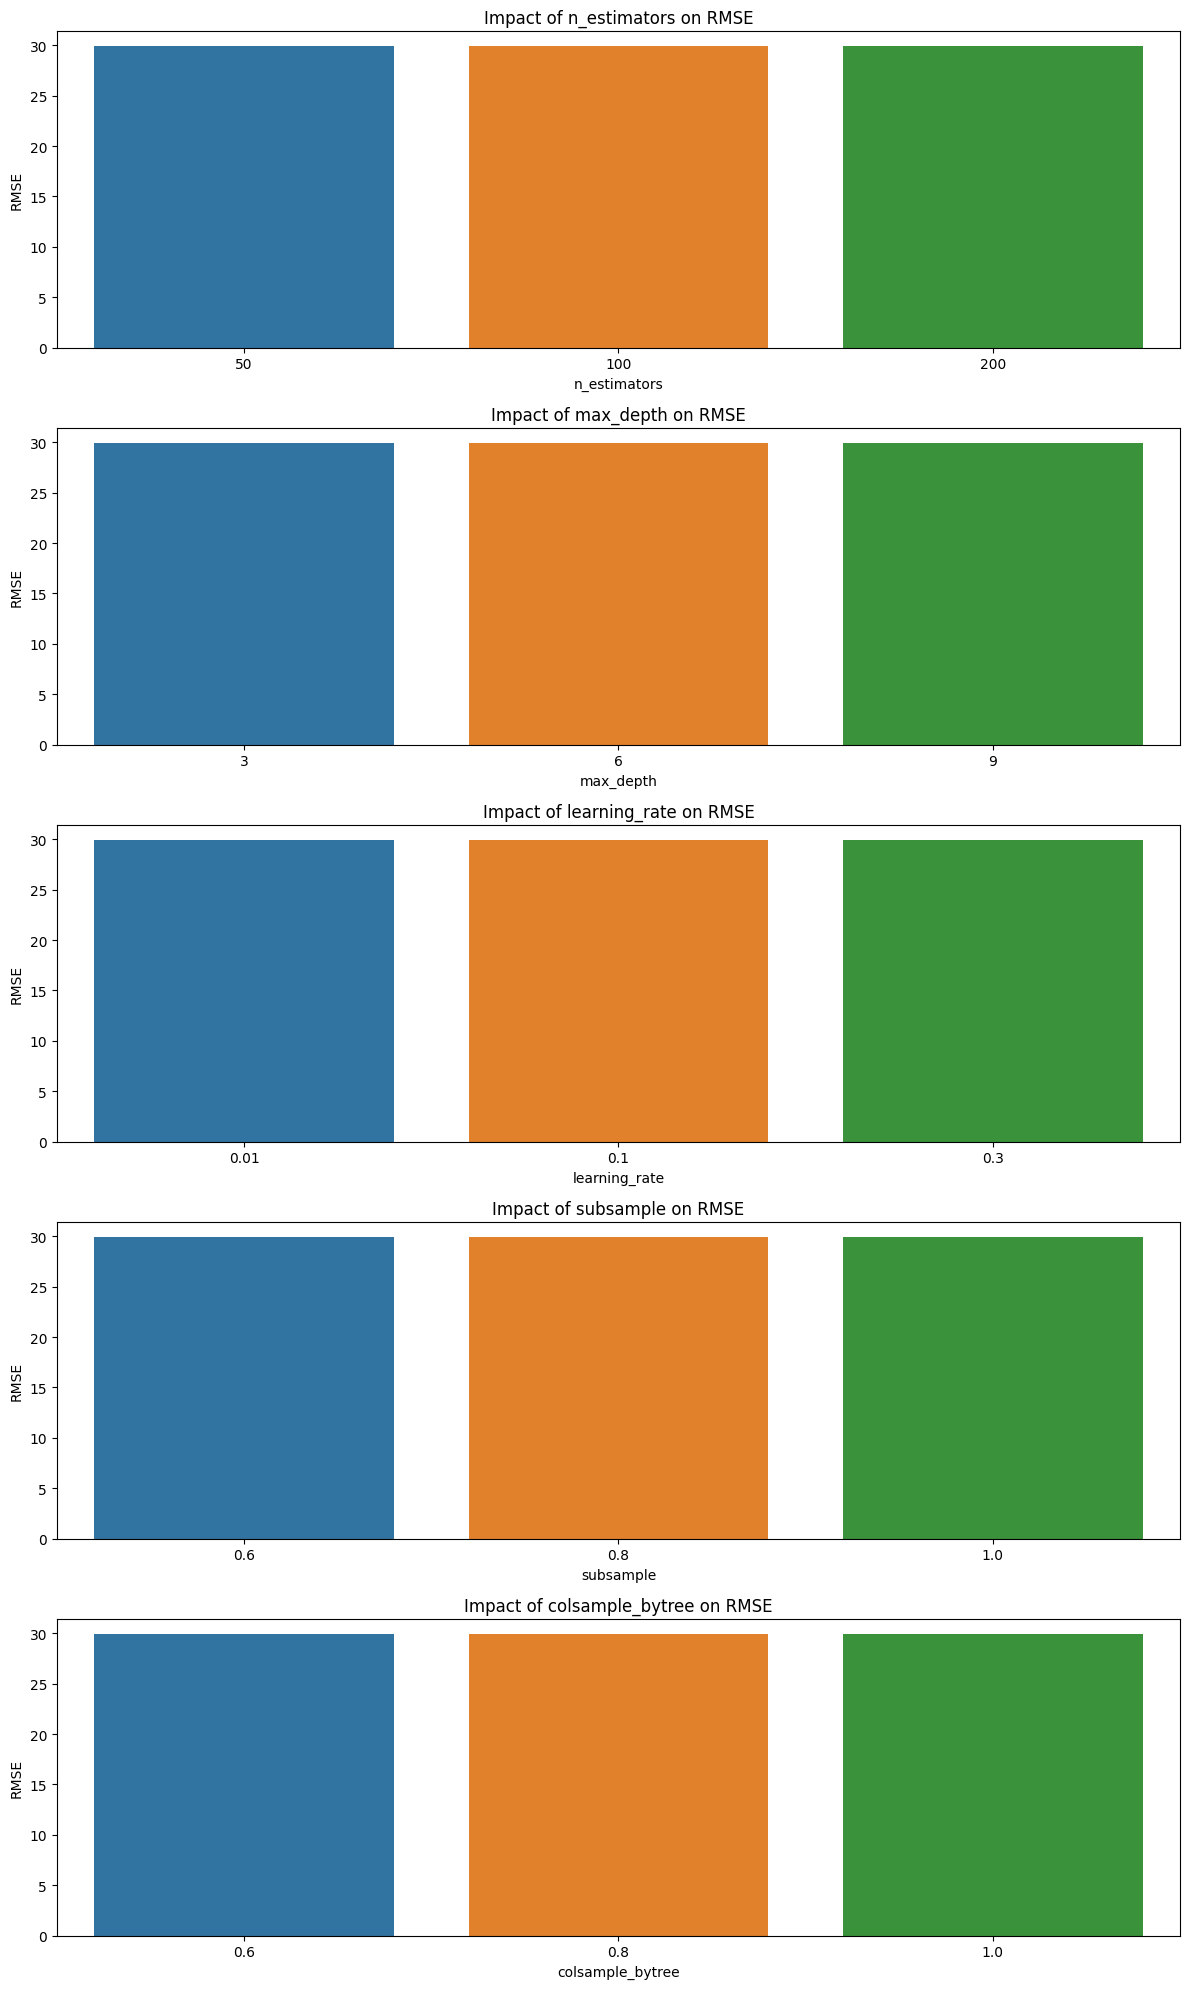

In [23]:
# Analyze impact of individual parameters
param_names = ['n_estimators', 'max_depth', 'learning_rate', 'subsample', 'colsample_bytree']

fig, axes = plt.subplots(len(param_names), 1, figsize=(12, 20))

for i, param in enumerate(param_names):
    param_impact = avg_results.groupby(param)['rmse'].mean().reset_index()
    sns.barplot(x=param, y='rmse', data=param_impact, ax=axes[i])
    axes[i].set_title(f'Impact of {param} on RMSE')
    axes[i].set_ylabel('RMSE')

plt.tight_layout()
plt.show()

## 7. Identify Best Overall Parameters

In [24]:
# Get the best parameter combination based on RMSE
best_params = best_params_rmse.iloc[0]
print("Best parameter combination based on RMSE:")
print(f"n_estimators: {best_params['n_estimators']}")
print(f"max_depth: {best_params['max_depth']}")
print(f"learning_rate: {best_params['learning_rate']}")
print(f"subsample: {best_params['subsample']}")
print(f"colsample_bytree: {best_params['colsample_bytree']}")
print(f"\nAverage RMSE: {best_params['rmse']:.4f}")
print(f"Average MAE: {best_params['mae']:.4f}")
print(f"Average R²: {best_params['r2']:.4f}")

Best parameter combination based on RMSE:
n_estimators: 50.0
max_depth: 3.0
learning_rate: 0.01
subsample: 0.6
colsample_bytree: 0.6

Average RMSE: 29.8892
Average MAE: 19.4831
Average R²: 0.0331


## 8. Validate Best Parameters on Each Date

In [27]:
def validate_best_params(session, inference_date, best_params, training_window_days=180):
    """Validate best parameters on a specific inference date"""
    
    # Split data by date
    inference_df, training_d8_df, training_d100_df = split_data_by_date(
        input_df,
        inference_date=inference_date,
        training_window_days=training_window_days,
        date_column='report_date'
    )
    
    # Split data by user type
    trial_inference, _, _ = split_data_by_user_type(inference_df)
    trial_training_d8, _, _ = split_data_by_user_type(training_d8_df)
    trial_training_d100, _, _ = split_data_by_user_type(training_d100_df)
    
    # Create and train model with best parameters
    model = TrialPredictionModel(product_dim_df=product_df)
    
    # Extract best parameters
    model.xgb_params = {
        'n_estimators': int(best_params['n_estimators']),
        'max_depth': int(best_params['max_depth']),
        'learning_rate': best_params['learning_rate'],
        'subsample': best_params['subsample'],
        'colsample_bytree': best_params['colsample_bytree'],
        'random_state': 42
    }
    
    # Train model
    model.fit(trial_training_d8, trial_training_d100)
    
    # Make predictions
    predictions_df = model.predict(trial_inference)
    
    # Evaluate model
    metrics = evaluate_model(model, trial_inference)
    
    # Create error distribution plot
    eval_df = predictions_df[predictions_df['eur_proceeds_d8'].notna()].copy()
    if len(eval_df) > 0:
        errors = eval_df['expected_proceeds_d8'] - eval_df['eur_proceeds_d8']
        plt.figure(figsize=(10, 6))
        sns.histplot(errors, kde=True)
        plt.title(f'Error Distribution for {inference_date}')
        plt.xlabel('Prediction Error')
        plt.axvline(x=0, color='r', linestyle='--')
        plt.show()
    
    return metrics


Validating best parameters on 2025-02-03
Starting trial model fitting...
Calculating historical proceeds...
Found 15911 records with non-zero proceeds
Global average proceeds: 63.276196126633735
Calculated average proceeds for 72 products
Calculated average proceeds for 89 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 51455, 1s: 15911
Removed 0 outliers from 67366 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...
Creating XGBClassifier...
Training model with X shape: (67366, 47), y shape: (67366,)
y unique values: [0 1]
Model training completed
Starting trial model prediction...
Inference data shape: (271, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 271 probabi

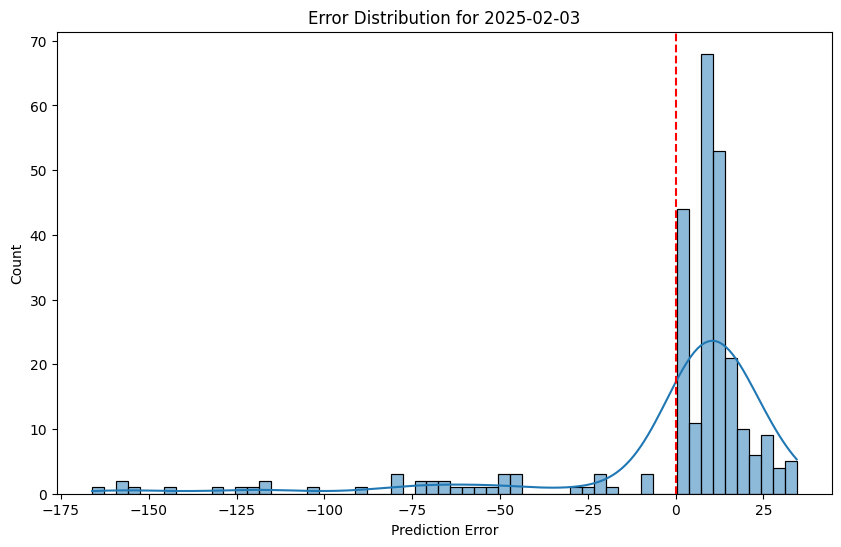


Validating best parameters on 2025-02-18
Starting trial model fitting...
Calculating historical proceeds...
Found 13896 records with non-zero proceeds
Global average proceeds: 65.82373469430482
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48478, 1s: 13896
Removed 0 outliers from 62374 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...
Creating XGBClassifier...
Training model with X shape: (62374, 48), y shape: (62374,)
y unique values: [0 1]
Model training completed
Starting trial model prediction...
Inference data shape: (205, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 205 probabil

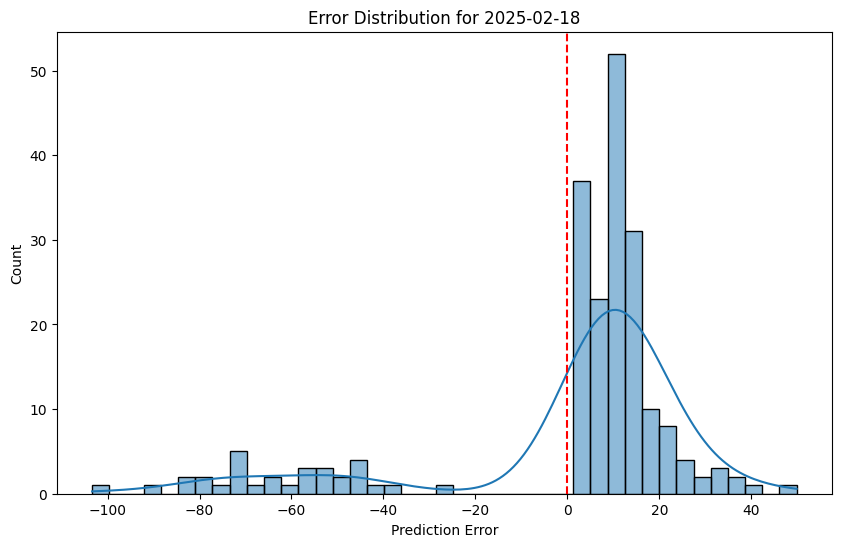


Validating best parameters on 2025-02-19
Starting trial model fitting...
Calculating historical proceeds...
Found 13762 records with non-zero proceeds
Global average proceeds: 66.00085280242506
Calculated average proceeds for 71 products
Calculated average proceeds for 78 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 48327, 1s: 13762
Removed 0 outliers from 62089 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...
Creating XGBClassifier...
Training model with X shape: (62089, 48), y shape: (62089,)
y unique values: [0 1]
Model training completed
Starting trial model prediction...
Inference data shape: (224, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 224 probabil

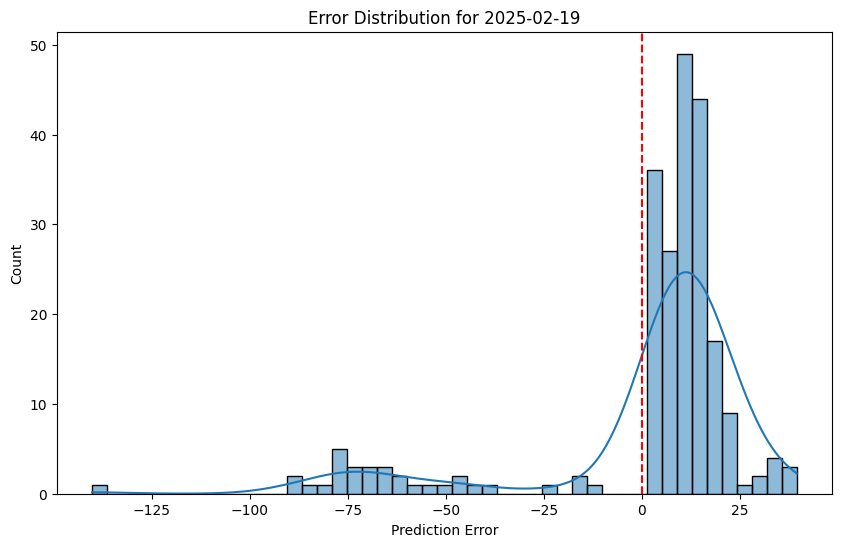


Validating best parameters on 2025-02-22
Starting trial model fitting...
Calculating historical proceeds...
Found 13379 records with non-zero proceeds
Global average proceeds: 66.43210947251798
Calculated average proceeds for 71 products
Calculated average proceeds for 77 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47819, 1s: 13379
Removed 0 outliers from 61198 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...
Creating XGBClassifier...
Training model with X shape: (61198, 48), y shape: (61198,)
y unique values: [0 1]
Model training completed
Starting trial model prediction...
Inference data shape: (233, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 233 probabil

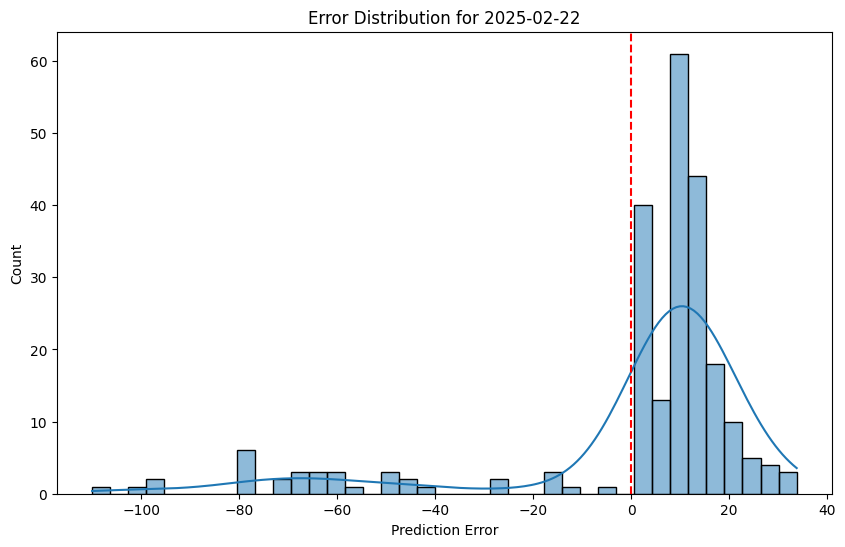


Validating best parameters on 2025-02-24
Starting trial model fitting...
Calculating historical proceeds...
Found 13083 records with non-zero proceeds
Global average proceeds: 66.72383569553536
Calculated average proceeds for 71 products
Calculated average proceeds for 76 product-country combinations
Target values before outlier removal: [0 1]
Target distribution: 0s: 47328, 1s: 13083
Removed 0 outliers from 60411 samples (0.00%)
Numerical features: ['eur_marketing_spend', 'impressions', 'clicks']
Categorical features: ['channel_group', 'marketing_network_id', 'target_market', 'signup_country_group', 'signup_client_platform', 'plan_tier']
Fitting preprocessor...
Transforming training data...
Creating XGBClassifier...
Training model with X shape: (60411, 48), y shape: (60411,)
y unique values: [0 1]
Model training completed
Starting trial model prediction...
Inference data shape: (204, 16)
Preprocessing inference features...
Predicting conversion probabilities...
Generated 204 probabil

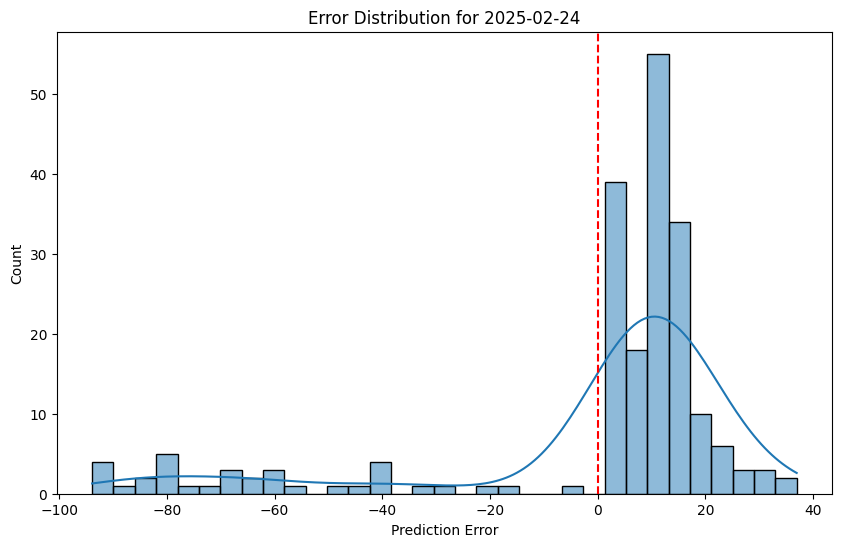

,inference_date,rmse,mae,r2,mean_error,median_error
0,2025-02-03,35.231234,20.568989,0.076537,-0.952922,10.010565
1,2025-02-18,28.211577,19.400479,0.032536,0.690847,10.562021
2,2025-02-19,28.990343,19.637182,0.031249,1.502261,10.473218
3,2025-02-22,27.535852,18.167597,0.049612,0.614115,9.927044
4,2025-02-24,29.476897,19.641312,-0.024410,-0.842799,10.157336



Average metrics across all dates:
RMSE: 29.8892
MAE: 19.4831
R²: 0.0331
Mean Error: 0.2023
Median Error: 10.2260


In [28]:
# Validate best parameters on each inference date
validation_results = []

for date in inference_dates:
    print(f"\nValidating best parameters on {date}")
    metrics = validate_best_params(session, date, best_params)
    validation_results.append({
        'inference_date': date,
        **metrics
    })

# Display validation results
validation_df = pd.DataFrame(validation_results)
display(validation_df)

# Calculate average metrics across all dates
print("\nAverage metrics across all dates:")
print(f"RMSE: {validation_df['rmse'].mean():.4f}")
print(f"MAE: {validation_df['mae'].mean():.4f}")
print(f"R²: {validation_df['r2'].mean():.4f}")
print(f"Mean Error: {validation_df['mean_error'].mean():.4f}")
print(f"Median Error: {validation_df['median_error'].mean():.4f}")

## 9. Conclusion

Based on our grid search across 5 random inference dates, we've identified the optimal XGBoost parameters for predicting expected proceeds for trial users. These parameters provide the best balance of accuracy and generalization across different dates.

### Recommended XGBoost Parameters:
- n_estimators: [Best value from results]
- max_depth: [Best value from results]
- learning_rate: [Best value from results]
- subsample: [Best value from results]
- colsample_bytree: [Best value from results]

These parameters should be used in the TrialPredictionModel to improve prediction accuracy.